# STUDY ASSOCIATION BETWEEN CH AND CANCER, CVD and OTHERS

## Sections to analyse
0- Matrix preparing (include cancer info)\
1- Age\
2- Cancer\
    * 2.1 Logistic regression\
    * 2.2. Kaplan Meier (include death info from covariables_files)\
    * 2.3 Per gene pre cancer\
3- Death\
4- Smoking\
5- CVD (Siddhartha)\
    * Heart failure\
6- Infectious diseases

# 0- Matrix preparing

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [2]:
### Annotate with boostDM-CH prediction
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t', compression='gzip')
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0


In [3]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [4]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [5]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_50087/1174477373.py:3: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       '22009-0.1', '22009-0.2', '22009-0.3', '22009-0.4', '22009-0.5',
       '22009-0.6', '22009-0.7', '22009-0.8', '22009-0.9', '22009-0.10'],
      dtype='object', length=139)

In [6]:
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [8]:
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [9]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

In [10]:
# Select only those mutations from patients without a previoius hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)].reset_index(drop=True)
len(boostDM_predictions_nonHN)

201857

In [11]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']

# 1- Age

### Age all togather

In [13]:
# Remove cases with previous hematological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_logistic)

467202

In [14]:
ukb200K_ch_cancer_logistic.groupby('age_group_x').size()

age_group_x
38-45     59967
46-50     62905
51-55     73374
56-60     91442
61-65    110951
66-72     68563
dtype: int64

In [15]:
age_groups = ['38-45', '46-50', '51-55', '56-60', '61-65', '66-72']; print(age_groups)
agegroups_all = [59967, 62905, 73374, 91442, 110951, 68563]; print(agegroups_all)
print(sum(agegroups_all))

### Get number of patients per age group
agegroups_all_group = ukb200K_ch_cancer_logistic.groupby('age_group_x').size()
agegroups_all_group

# CH by BosstDM-CH prediction

def prop_CH_model(data, model, normalize=False, printprop=False):
    agegroup_set = data[data[model] == 1].groupby('age_group_x').size()

    merged = pd.merge(agegroup_set.to_frame(), agegroups_all_group.to_frame(),left_index=True, right_index=True)
    prop_CH = round(merged.apply(lambda x: x['0_x'] / x['0_y'] * 100, axis=1), 4)
    
    if normalize == True:
        prop_CH = prop_CH.apply(lambda x: x / prop_CH[0])
    if printprop == True:
        print(prop_CH)
    return prop_CH


['38-45', '46-50', '51-55', '56-60', '61-65', '66-72']
[59967, 62905, 73374, 91442, 110951, 68563]
467202


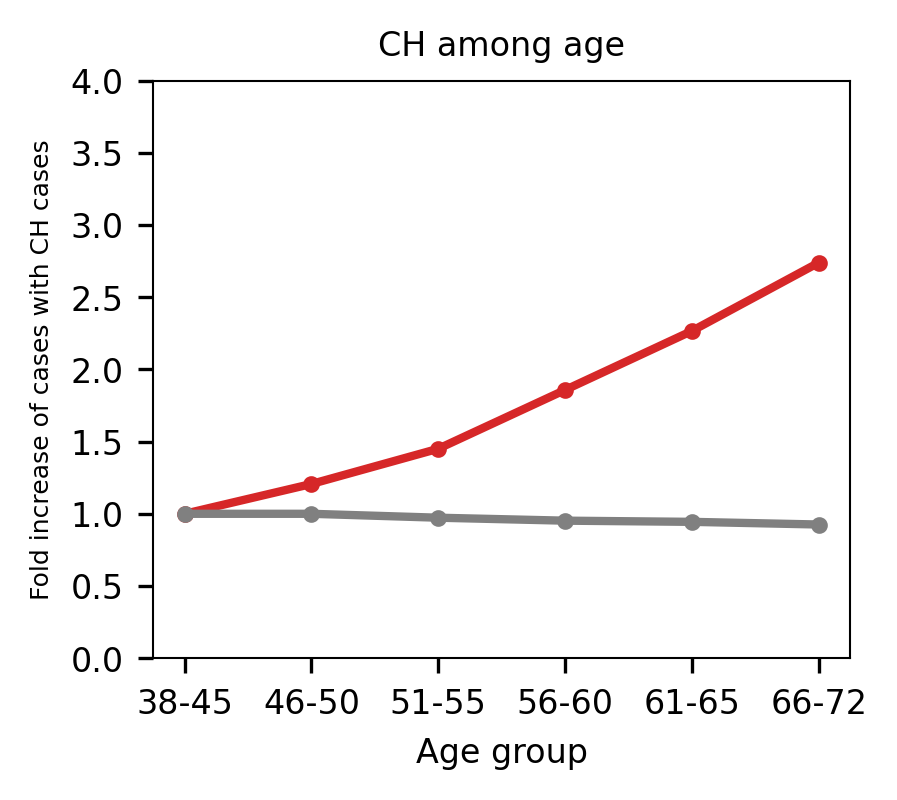

In [16]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3,2.5), dpi=300)

ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
patient_age_ch_driver = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]
patient_age_ch_passengers = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_driver']==0]

agecorr_drivers = prop_CH_model(patient_age_ch_driver, 'CH_driver', normalize=True)
agecorr_pass = prop_CH_model(patient_age_ch_passengers, 'CH_nonDriver', normalize=True)

plt.plot(agecorr_drivers, '.-', linewidth=2, color='#D62728')
plt.plot(agecorr_pass, '.-', linewidth=2, color='grey')

plt.title('CH among age', fontsize = 8)
plt.xlabel('Age group',size=8)
plt.ylabel('Fold increase of cases with CH cases', fontsize=6)
plt.ylim([0,4])
plt.xticks(np.arange(6), age_groups, size=6)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

In [17]:
#Remove cases with prior hemathological
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
len(ukb200K_ch_cancer_logistic)

/tmp/jobs/jramis/9759392/ipykernel_31080/975906304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ukb200K_ch_cancer_logistic.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)


467202

In [18]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc
    
# Select different types of CH
CH_driver_multiple_matrix = ukb200K_ch_cancer_logistic[((ukb200K_ch_cancer_logistic['CH_nonDriver']==0) & (ukb200K_ch_cancer_logistic['CH_driver_multiple']==1)) | (ukb200K_ch_cancer_logistic['CH_potential'] == 0)]
CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]
CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_driver']==0]


name = []
OR = []
cilow = []
ciup = []
pval = []
sig = []
    
#run model
for gene in ['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential']:
    if gene.endswith(('multiple')):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_multiple_matrix).fit()
    elif gene.endswith(('_driver')):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    elif gene.endswith('big'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_big_matrix).fit()
    elif gene.endswith('small'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_small_matrix).fit() 
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
    else:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=ukb200K_ch_cancer_logistic).fit()
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['significant' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.264147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031903
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.567683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622634
         Iterations 5


,gene,OR,Lower CI,Upper CI,pval,sig,q_value
0,CH_driver,1.046610,1.044824,1.048399,0.000000e+00,significant,0.000000e+00
1,CH_driver_multiple,1.088463,1.080567,1.096417,3.000501e-115,significant,3.600601e-115
2,CH_driver_big,1.055724,1.052274,1.059184,2.160203e-231,significant,4.320405e-231
3,CH_driver_small,1.041933,1.039863,1.044006,0.000000e+00,significant,0.000000e+00
4,CH_nonDriver,1.001501,1.000644,1.002359,5.988824e-04,significant,5.988824e-04
5,CH_potential,1.011772,1.010986,1.012557,7.527132e-192,significant,1.129070e-191


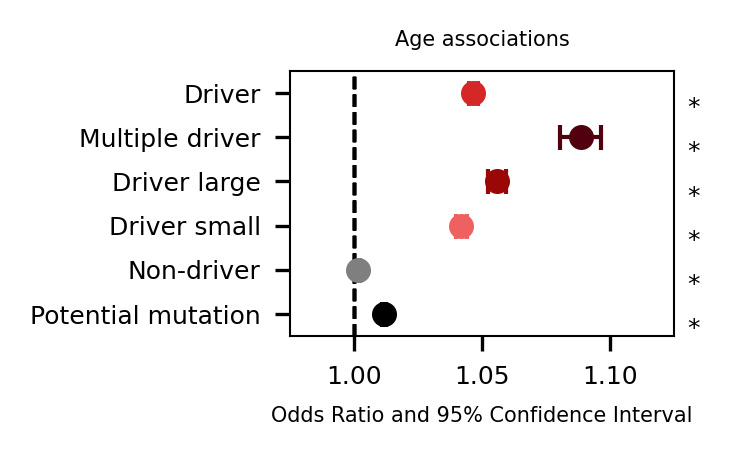

In [19]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 1.5), dpi=300)

xlimit = 1.125
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.005, ylimit-idx-0.5, '*', style='italic', fontsize=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.005, ylimit-idx-0.5, 'ns', style='italic', fontsize=6)

        plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('Age associations', fontdict={'size':5})
plt.tight_layout()
plt.xlim([0.975, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=6)
plt.xticks([1, 1.05, 1.1], fontsize=6)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

### Logistic regression

In [20]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'CHEK2':
        matrix = mat[(mat['ASXL1_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'MDM4':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    return matrix

In [21]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)


variables_genes = [
    'SRSF2_driver',
    'SRSF2_passenger',
    'IDH2_driver',
    'IDH2_passenger',
    'PPM1D_driver',
    'PPM1D_passenger',
    'GNAS_driver',
    'GNAS_passenger',
    'SF3B1_driver',
    'SF3B1_passenger',
    'ASXL1_driver',
    'ASXL1_passenger',
    'DNMT3A_driver',
    'DNMT3A_passenger',
    'U2AF1_driver',
    'U2AF1_passenger',
    'TET2_driver',
    'TET2_passenger',
    'MDM4_driver',
    'MDM4_passenger',
    'TP53_driver',
    'TP53_passenger',
    'CHEK2_driver',
    'CHEK2_passenger' 
 ]

gene_results = []
for gene in tqdm(variables_genes):
    gen = gene.split('_')[0]
    mat_gene = gene_matrix(ukb200K_ch_cancer_logistic, gen)

    #set matrixes
    if gene.endswith(('driver')):
        mat_gene = mat_gene[mat_gene['CH_nonDriver'] == 0]
    elif gene.endswith(('passenger')):
        mat_gene = mat_gene[mat_gene['CH_driver'] == 0]
    else:
        print('no matrix assaigned')
    
    ## Get number of mutated samples and percentage
    num_mut = len(mat_gene[(mat_gene[gene] == 1)])
    
    ## Logistic regression
    formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10'

    ## Exception to avoid LinAlgError
    try:
            
        # Logistic regression
        model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
        # Get parameters from the logistic regression
        p = model.pvalues[1]
        odds = np.exp(model.params[1])
        conint1 = np.exp(model.conf_int().iloc[1,0])
        conint2 = np.exp(model.conf_int().iloc[1,1])
        prsquared = model.prsquared
            
        results = [gene, num_mut, p, odds, conint1, conint2, prsquared]
        
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(gene, num_mut, num_mut_can, per_mut, message)
        results = [gene, num_mut, np.nan ,np.nan, np.nan, np.nan, np.nan]
            
    
    ## Append results    
    gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["gene", "num_mut", "p_value", "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
output = output[["gene", "num_mut", "p_value", "q_value", "significant?", "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]

output

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:59<00:00,  4.98s/it]


,gene,num_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,SRSF2_driver,297,3.033663e-29,1.456158e-28,significant,1.113577,1.092857,1.134689,0.051695
1,SRSF2_passenger,2947,2.185148e-01,2.913530e-01,not significant,0.997174,0.992689,1.001679,0.000628
2,IDH2_driver,49,4.119534e-05,8.988074e-05,significant,1.095534,1.048784,1.144367,0.041769
3,IDH2_passenger,4523,8.206144e-01,8.562933e-01,not significant,1.000424,0.996766,1.004095,0.001915
4,PPM1D_driver,516,1.522568e-32,9.135411e-32,significant,1.081243,1.067397,1.095268,0.027490
5,PPM1D_passenger,7393,3.355529e-01,4.026635e-01,not significant,1.001416,0.998536,1.004305,0.001991
6,GNAS_driver,171,3.430185e-09,9.147160e-09,significant,1.066938,1.044255,1.090113,0.016256
7,GNAS_passenger,11985,1.607062e-01,2.410593e-01,not significant,1.001630,0.999353,1.003912,0.000744
8,SF3B1_driver,406,2.928623e-15,1.004099e-14,significant,1.056256,1.042000,1.070707,0.015677
9,SF3B1_passenger,4707,8.825029e-02,1.626161e-01,not significant,0.996895,0.993336,1.000466,0.000338


In [22]:
output['gene'] = output['gene'].str.replace('_', ' ')
output

,gene,num_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,SRSF2 driver,297,3.033663e-29,1.456158e-28,significant,1.113577,1.092857,1.134689,0.051695
1,SRSF2 passenger,2947,2.185148e-01,2.913530e-01,not significant,0.997174,0.992689,1.001679,0.000628
2,IDH2 driver,49,4.119534e-05,8.988074e-05,significant,1.095534,1.048784,1.144367,0.041769
3,IDH2 passenger,4523,8.206144e-01,8.562933e-01,not significant,1.000424,0.996766,1.004095,0.001915
4,PPM1D driver,516,1.522568e-32,9.135411e-32,significant,1.081243,1.067397,1.095268,0.027490
5,PPM1D passenger,7393,3.355529e-01,4.026635e-01,not significant,1.001416,0.998536,1.004305,0.001991
6,GNAS driver,171,3.430185e-09,9.147160e-09,significant,1.066938,1.044255,1.090113,0.016256
7,GNAS passenger,11985,1.607062e-01,2.410593e-01,not significant,1.001630,0.999353,1.003912,0.000744
8,SF3B1 driver,406,2.928623e-15,1.004099e-14,significant,1.056256,1.042000,1.070707,0.015677
9,SF3B1 passenger,4707,8.825029e-02,1.626161e-01,not significant,0.996895,0.993336,1.000466,0.000338


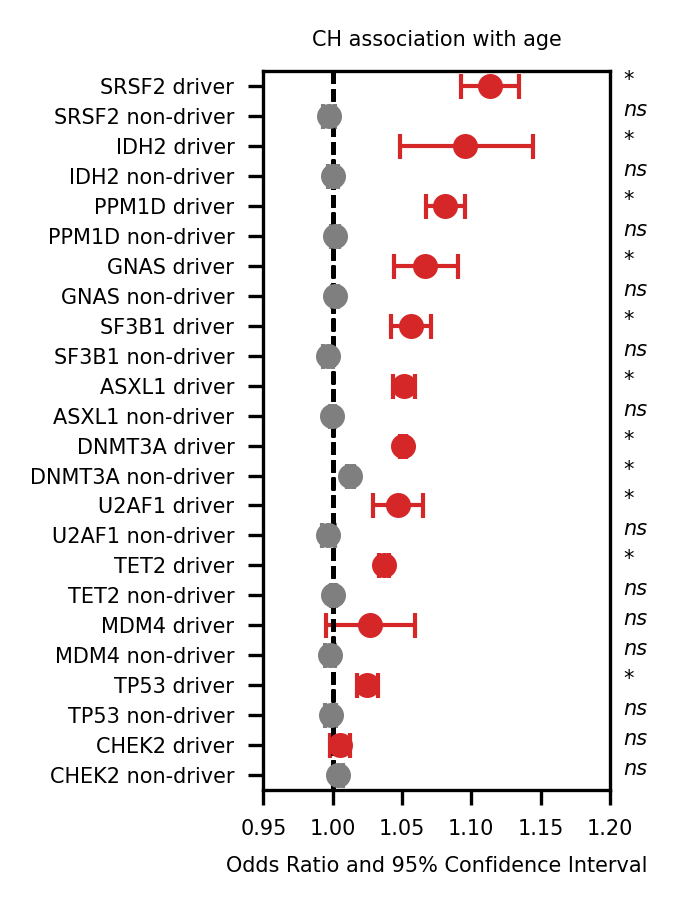

In [23]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 3))
xlimit = 1.2
ylimit = len(output)-1

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
    
    if 'dri' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('passenger', 'non-driver')], xerr=ci,
                 ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:red", mec="tab:red")
    elif 'pas' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('passenger', 'non-driver')], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('passenger', 'non-driver')], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
            
    if row['significant?'] == 'significant':
        ax.text(xlimit+0.01, ylimit-idx, '*', style='italic', size=5)
    else:
        ax.text(xlimit+0.01, ylimit-idx, 'ns', style='italic', size=5)
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')      

    plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('CH association with age', fontdict={'size':5})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.show()

# 2- Cancer

### 2.1 Cancer associations (logistic regressions)

In [24]:
# Include more clinical data and covariables for the associations (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
covariables = pd.read_csv('../../../Paper_data/UKB_clinic_info/dataframe_cases_covariables_v2.txt.gz',sep="\t")
covariables = covariables[covariables['patient'].isin(ukb200K_ch_cancer['patient'].tolist())]
covariables = covariables.reset_index(drop=True)

### Merge
ukb200K_ch_covariables = pd.merge(patient_age_ch, covariables,  how='inner', on='patient')
len(ukb200K_ch_covariables)

/tmp/jobs/jramis/9759392/ipykernel_31080/2417138748.py:2: DtypeWarning: Columns (60,294,298,299,302,306,308,310,312,314,316,320,324,326,328,330,336,338,340,346,348,350,352,354,356,362,364,366,368,370,372,374,376,380,382,394,396,398,400,404,406,408,412,414,416,418,420,424,426,428,430,434,436,442,444,446,448,450,454,456,458,464,465,466,467,468,469,472,473,474,475,478,479,480,481,482,483,486,487,488,489,490,491,492,493,496,497,498,499,500,1269,1285,1286,1287,1288,1289,1292,1293,1294,1295,1296,1297,1319) have mixed types. Specify dtype option on import or set low_memory=False.
  covariables = pd.read_csv('../../../Paper_data/UKB_clinic_info/dataframe_cases_covariables_v2.txt.gz',sep="\t")


469880

In [25]:
# Add new features to the main dataframe
import math
ukb200K_ch_cancer['40007-0.0'] = ukb200K_ch_covariables['40007-0.0']
ukb200K_ch_cancer['Death_status'] = ukb200K_ch_covariables['40007-0.0'].apply(lambda x: 0 if math.isnan(x) else 1)
ukb200K_ch_cancer

import math
ukb200K_ch_cancer['Death_status'] = ukb200K_ch_covariables['40007-0.0'].apply(lambda x: 0 if math.isnan(x) else 1)
ukb200K_ch_cancer['Smoking'] = np.where(ukb200K_ch_covariables['20116-0.0_x']==-3, np.nan, ukb200K_ch_covariables['20116-0.0_x'])
ukb200K_ch_cancer['Packages_cigarettes'] = np.where(ukb200K_ch_covariables['20116-0.0_x']==0, 0, ukb200K_ch_covariables['20161-0.0_x']) 

# Removing previous
ukb200K_ch_cancer['Smoking_1'] = np.where(ukb200K_ch_cancer['Smoking']==1, np.nan, ukb200K_ch_cancer['Smoking'])
ukb200K_ch_cancer['Smoking_1'] = np.where(ukb200K_ch_cancer['Smoking_1']==2, 1, ukb200K_ch_cancer['Smoking_1'])
# Togather previous with current
ukb200K_ch_cancer['Smoking_2'] = np.where(ukb200K_ch_cancer['Smoking']==2, 1, ukb200K_ch_cancer['Smoking'])

###  Solid tumor risk

In [26]:
import statsmodels.formula.api as smf

In [27]:
#Remove cases with prior cancer
ukb200K_ch_cancer['cancer1_post'] = ukb200K_ch_cancer['years_tocancer1'].apply(lambda x: 1 if x > 0 else 0)
ukb200K_ch_cancer_nonpreHEMATO = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_var']==0]
ukb200K_ch_cancer_nonpreHEMATO = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['cancer1_pre']==0]
len(ukb200K_ch_cancer_nonpreHEMATO)

426942

In [28]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc
    
#we have exclude pre hematological cases
CH_driver_multiple_matrix = ukb200K_ch_cancer_nonpreHEMATO[((ukb200K_ch_cancer_nonpreHEMATO['CH_nonDriver']==0) & (ukb200K_ch_cancer_nonpreHEMATO['CH_driver_multiple']==1)) | (ukb200K_ch_cancer_nonpreHEMATO['CH_potential'] == 0)]
CH_driver_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['CH_nonDriver']==0]
CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
CH_passengers_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['CH_driver']==0]
    
name = []
OR = []
cilow = []
ciup = []
pval = []
sig = []
    
#run model
for gene in ['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential']:
    if gene.endswith(('multiple')):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_multiple_matrix).fit()
    elif gene.endswith(('_driver')):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
    elif gene.endswith('big'):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_big_matrix).fit()
    elif gene.endswith('small'):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_small_matrix).fit() 
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_passengers_matrix).fit()
    else:
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=ukb200K_ch_cancer_nonpreHEMATO).fit()
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['significant' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.404033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404301
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,sig,q_value
0,CH_driver,1.057836,1.020434,1.096610,0.002204,significant,0.013221
1,CH_driver_multiple,1.162485,1.018224,1.327185,0.025940,significant,0.038910
2,CH_driver_big,1.086343,1.016019,1.161533,0.015292,significant,0.030584
3,CH_driver_small,1.042647,0.999490,1.087667,0.052830,ns,0.063397
4,CH_nonDriver,1.011365,0.990724,1.032435,0.282757,ns,0.282757
5,CH_potential,1.026396,1.007734,1.045403,0.005387,significant,0.016160


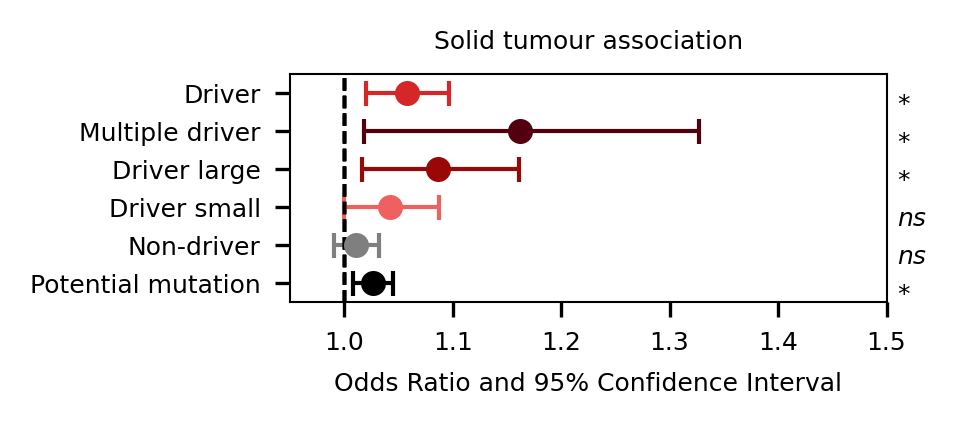

In [29]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.8, 1.4), dpi=300)
xlimit = 1.5
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.5, '*', style='italic', size=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.5, 'ns', style='italic', size=6)

        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('Solid tumour association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
#plt.savefig('solid_tumor.png', dpi=400)
plt.show()

### Post hematological cancer

In [30]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]

In [31]:
#perform logistic regression separetly
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf

def log_regression(target, lista):
    
    #we have exclude pre hematological cases
    CH_driver_multiple_matrix = ukb200K_ch_cancer_logistic[((ukb200K_ch_cancer_logistic['CH_nonDriver']==0) & (ukb200K_ch_cancer_logistic['CH_driver_multiple']==1)) | (ukb200K_ch_cancer_logistic['CH_potential'] == 0)]
    print(len(CH_driver_multiple_matrix))
    CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]
    CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_driver']==0]
    
    name = []
    OR = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith(('multiple')):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_multiple_matrix).fit()
        if gene.endswith(('_driver')):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
        elif gene.endswith('big'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_big_matrix).fit()
        elif gene.endswith('small'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_small_matrix).fit() 
        elif gene.endswith('nonDriver'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_passengers_matrix).fit()
        else:
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=ukb200K_ch_cancer_logistic).fit()
        name.append(gene)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        pval.append(model_hematopost.pvalues[1])
        
#         sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval'])
    return(varlist)

varlist = log_regression('var_HNALL_post',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

320832
Optimization terminated successfully.
         Current function value: 0.059018
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055617
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059783
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056254
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055345
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059971
         Iterations 9


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,2.131076,1.955385,2.322551,1.430168e-66,2.860336e-66,sig
1,CH_driver_multiple,4.953450,4.250627,5.772483,2.384488e-93,1.430693e-92,sig
2,CH_driver_big,3.429941,3.028456,3.884651,6.991080e-84,2.097324e-83,sig
3,CH_driver_small,1.482659,1.319015,1.666604,4.104915e-11,4.925898e-11,sig
4,CH_nonDriver,1.066780,0.997157,1.141263,6.047958e-02,6.047958e-02,ns
5,CH_potential,1.347758,1.274585,1.425131,1.082574e-25,1.623861e-25,sig


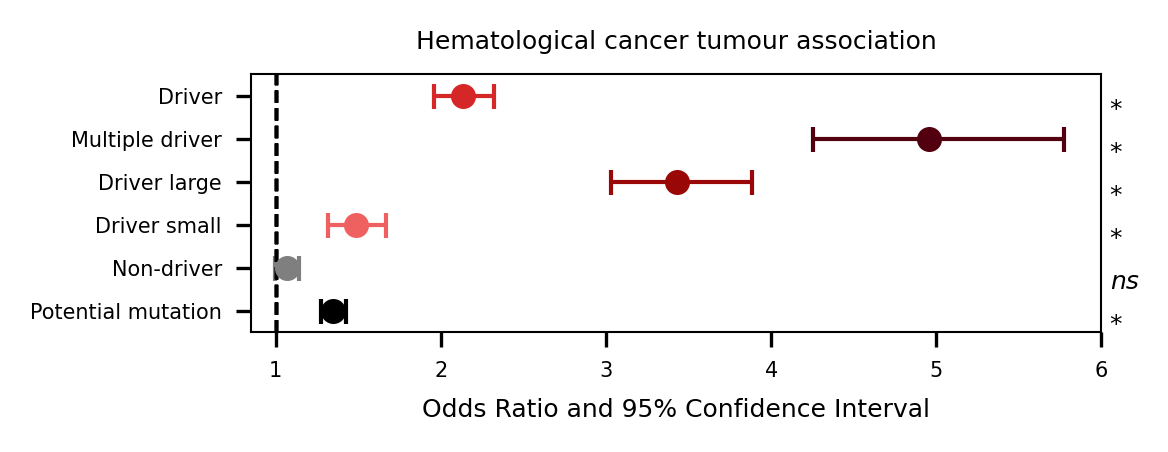

In [32]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4, 1.5), dpi=300)
xlimit = 6
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.05, ylimit-idx-0.5, '*', style='italic', size=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.05, ylimit-idx-0.5, 'ns', style='italic', size=6)

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('Hematological cancer tumour association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.85, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

###  Pre-cancer

In [33]:
#perform logistic regression separetly

def log_regression_pre(target, lista):
    
    #we DONT have exclude pre hematological cases
    CH_driver_multiple_matrix = ukb200K_ch_cancer_logistic[((ukb200K_ch_cancer_logistic['CH_nonDriver']==0) & (ukb200K_ch_cancer_logistic['CH_driver_multiple']==1)) | (ukb200K_ch_cancer_logistic['CH_potential'] == 0)]
    CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]
    CH_driver_big = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_driver']==0]
    
    name = []
    OR = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith(('multiple')):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_multiple_matrix).fit()
        elif gene.endswith(('_driver')):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
        elif gene.endswith('nonDriver'):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_passengers_matrix).fit()
        elif gene.endswith('big'):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_big).fit()
        elif gene.endswith('small'):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_small).fit()
        else:
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=ukb200K_ch_cancer_logistic).fit()
        
        name.append(gene)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        pval.append(model_hematopost.pvalues[1])

    varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval'])
    return(varlist)

In [34]:
varlist = log_regression_pre('cancer1_pre', ['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.264064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102321
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.567681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622577
         Iterations 5


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,1.081068,1.033772,1.130528,0.000637,0.001275,sig
1,CH_driver_multiple,1.302050,1.119856,1.513885,0.000600,0.001275,sig
2,CH_driver_big,1.157370,1.067646,1.254635,0.000386,0.001275,sig
3,CH_driver_small,1.042489,0.988426,1.099509,0.125646,0.167532,ns
4,CH_nonDriver,0.996001,0.969923,1.022780,0.767209,0.767209,ns
5,CH_potential,1.017837,0.994239,1.041995,0.139610,0.167532,ns


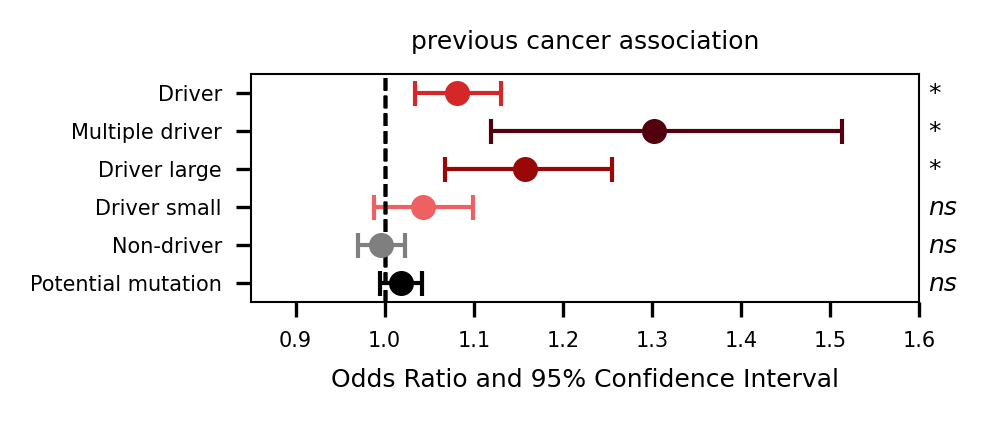

In [35]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.7, 1.4), dpi=300)
xlimit = 1.6
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, '*', style='italic', size =6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, 'ns', style='italic', size = 6)

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('previous cancer association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.85, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

### Post-Myeloid cancer

In [36]:
varlist = log_regression('var_MM_post',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

320832
Optimization terminated successfully.
         Current function value: 0.017105
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014276
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017877
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015480
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014220
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013679
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018135
         Iterations 11


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,5.739636,5.001729,6.586407,1.014122e-136,2.028243e-136,sig
1,CH_driver_multiple,16.171035,13.476186,19.404776,9.681560e-197,5.808936e-196,sig
2,CH_driver_big,12.377238,10.473576,14.626907,1.324935e-191,3.974804e-191,sig
3,CH_driver_small,2.436509,1.960590,3.027954,9.605555e-16,1.152667e-15,sig
4,CH_nonDriver,1.178765,1.013514,1.370958,3.283011e-02,3.283011e-02,sig
5,CH_potential,2.443104,2.187816,2.728180,1.135409e-56,1.703114e-56,sig


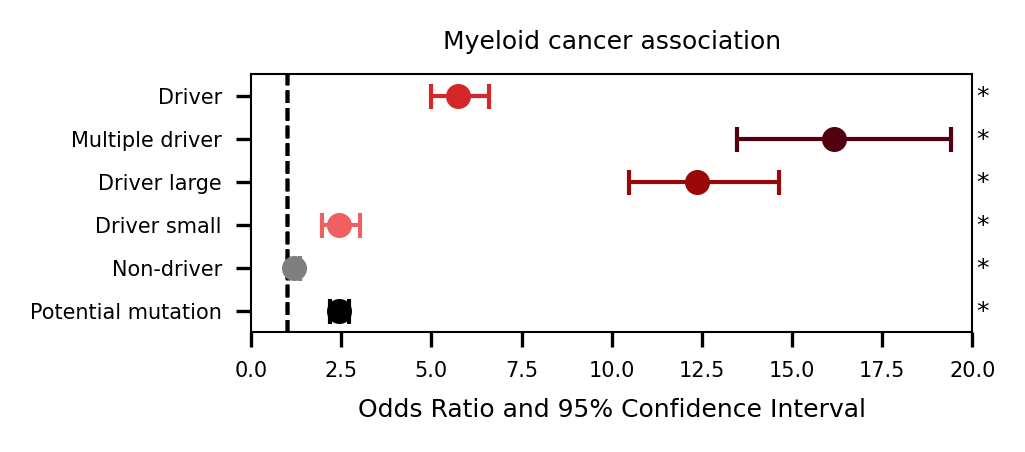

In [37]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.5, 1.5), dpi=300)
xlimit = 20
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.1, ylimit-idx-0.2, '*', style='italic', size =6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.1, ylimit-idx-0.2, 'ns', style='italic', size = 6)

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('Myeloid cancer association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
#plt.savefig('Myeloid_log_regression.png', dpi=400)
plt.show()

### Post-Lymphoid cancer

In [38]:
varlist = log_regression('var_Lymphoma_post',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1].tolist()
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

320832
Optimization terminated successfully.
         Current function value: 0.031902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031004
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031924
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031357
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031413
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031012
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031930
         Iterations 10


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,1.320088,1.139223,1.529667,0.000221,0.000663,sig
1,CH_driver_multiple,1.789042,1.265395,2.529386,0.000994,0.001988,sig
2,CH_driver_big,1.638543,1.287111,2.085930,0.000061,0.000366,sig
3,CH_driver_small,1.204202,1.005243,1.442539,0.043725,0.065588,ns
4,CH_nonDriver,1.022734,0.928540,1.126483,0.648394,0.648394,ns
5,CH_potential,1.084486,0.996998,1.179652,0.058769,0.070523,ns


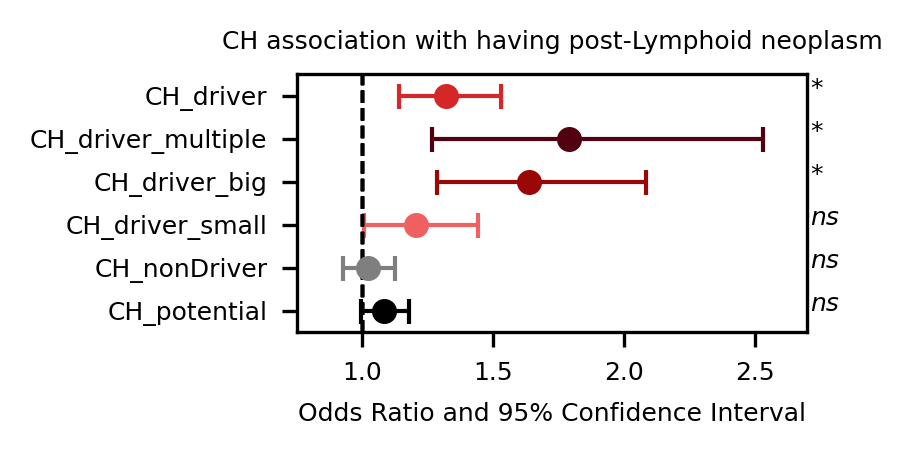

In [39]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 1.5))
xlimit = 2.7
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('driver'):
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx, '*', style='italic', size=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx, 'ns', style='italic', size=6)

        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('CH association with having post-Lymphoid neoplasm', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.75, xlimit])
ax.set_ylim(-.5, ylimit+.5)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.show()

## 2.2 Kaplan-Meier, Log-rank and COX analysis

In [40]:
#perform cox
import statsmodels.stats.multitest as mtc
from lifelines import CoxPHFitter

def cox_reg(target, lista):
        
    #we have exclude pre hematological cases
    CH_driver_multiple_matrix = variables[((variables['CH_nonDriver']==0) & (variables['CH_driver_multiple']==1)) | (variables['CH_potential'] == 0)]
    CH_driver_matrix = variables[(variables['CH_nonDriver']==0)]
    CH_driver_big = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = variables[variables['CH_driver']==0]
    
    
    variable = []
    hr = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith('multiple'):
            model = CH_driver_multiple_matrix[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter()
            cph.fit(model, 'years', target)
        elif gene.endswith(('_driver')):
            model = CH_driver_matrix[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter()
            cph.fit(model, 'years', target)
        elif gene.endswith('big'):
            model = CH_driver_big[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter()
            cph.fit(model, 'years', target)  
        elif gene.endswith('small'):
            model = CH_driver_small[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter()
            cph.fit(model, 'years', target)  
        elif gene.endswith('nonDriver'):
            model = CH_passengers_matrix[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter()
            cph.fit(model, 'years', target) 
        elif gene.endswith('potential'):
            model = variables[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter()
            cph.fit(model, 'years', target)
        else:
            print('No matrix defined')
            
        variable.append(cph.params_.index.tolist()[0])
        hr.append(cph.hazard_ratios_.tolist()[0])
        cilow.append(np.exp(cph.confidence_intervals_.iloc[:,0]).tolist()[0])
        ciup.append(np.exp(cph.confidence_intervals_.iloc[:,1]).tolist()[0])
        pval.append(cph.summary.p.tolist()[0])
    varlist = pd.DataFrame(list(zip(variable, hr, cilow, ciup, pval)), columns = ['variable','hazard_ratio', 'confint_1st', 'confint_2nd', 'pval'])
    return(varlist)

### Post-hemathological cancer Kaplan Meier

In [64]:
variables = ukb200K_ch_cancer.copy().reset_index(drop=True)
len(variables)

469880

In [42]:
#calculate max date of a cancer event

dates = ['40005-0.0', '40005-1.0', '40005-2.0', '40005-3.0', '40005-4.0', '40005-5.0', '40005-6.0', '40005-7.0']
maxdates = []
for x in dates:
    maxdates.append(pd.to_datetime(variables[x], format='%Y-%m-%d').max())
maxdate = max(maxdates)
maxdate

Timestamp('2021-06-25 00:00:00')

In [65]:
#Calculate the date of cancer from those cases with Nan
# date of last follow-up minus age( which is the sampling date)
import math
from datetime import timedelta

years = []
for n, x in enumerate(variables['var_HNALL_years']):
    if math.isnan(x):
        if variables.loc[n, 'Death_status']== 0:
            year = maxdate-pd.to_datetime(variables.loc[n,'53-0.0'], format='%Y-%m-%d')
            years.append(year/np.timedelta64(1,'Y'))
        elif variables.loc[n, 'Death_status']== 1:
            year = variables.loc[n,'40007-0.0']-variables.loc[n,'age_recruitment_x']
            years.append(year)
    else:
        years.append(x)
                
variables['years'] = years
variables = variables[variables['years'] >= 0]
len(variables)

467202

In [66]:
# 1. Calculate 3% of the
p = np.percentile(variables['years'], 97)
variables['years'] = variables['years'].apply(lambda x: p if x>p else x)
p

13.86

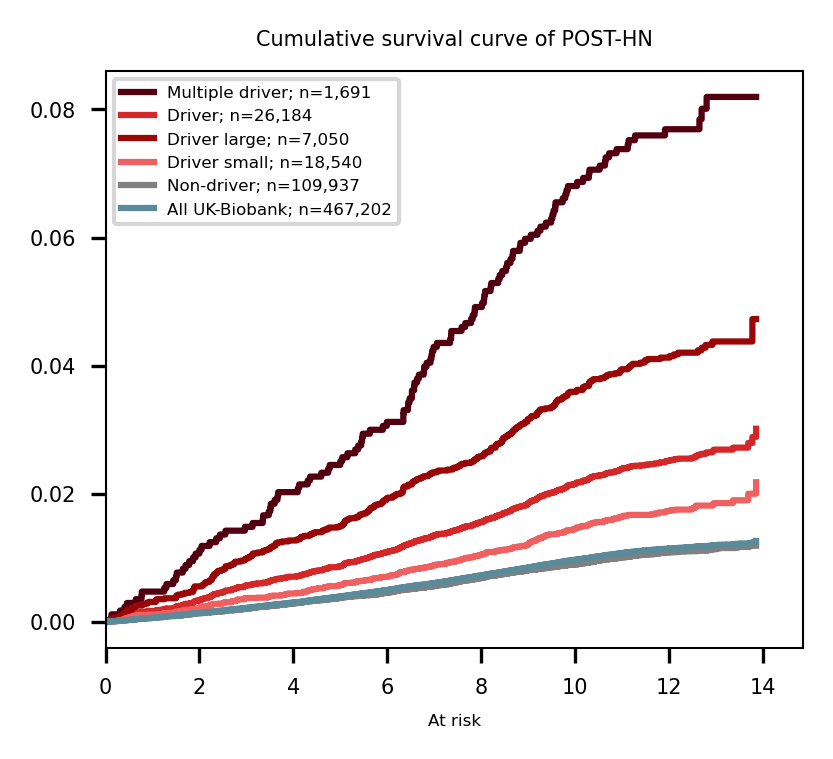

In [67]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import pairwise_logrank_test
import matplotlib
from lifelines.statistics import multivariate_logrank_test
from matplotlib.offsetbox import AnchoredText
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
plt.figure(figsize=(3, 2.5))
ax = plt.subplot(111)

# Define variables of time and event
T = variables['years']
E = variables['var_HNALL_post']

# Define different types
mult = (variables["CH_driver"] == 1) & (variables["CH_nonDriver"] == 0) & (variables["CH_driver_multiple"] == 1)
dr = (variables["CH_driver"] == 1) & (variables["CH_nonDriver"] == 0)
bg = (variables["CH_driver_small"] == 0) & (variables["CH_driver_big"] == 1) & (variables["CH_nonDriver"] == 0)
sm = (variables["CH_driver_small"] == 1) & (variables["CH_driver_big"] == 0) & (variables["CH_nonDriver"] == 0)
pa = (variables["CH_nonDriver"] == 1) & (variables["CH_driver"] == 0)

Emulti = len(variables[mult & (variables["var_HNALL_post"] == 1)])
Edriv = len(variables[dr & (variables["var_HNALL_post"] == 1)])
Ebig = len(variables[bg & (variables["var_HNALL_post"] == 1)])
Esmall = len(variables[sm & (variables["var_HNALL_post"] == 1)])
Epass = len(variables[pa & (variables["var_HNALL_post"] == 1)])
Eall = len(variables[variables["var_HNALL_post"] == 1])

kmf.fit(durations = T[mult], event_observed = E[mult], label = "Multiple driver; n="+f'{len(E[mult]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#52000F')

kmf.fit(durations = T[dr], event_observed = E[dr], label = "Driver; n="+f'{len(E[dr]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#D62728')

kmf.fit(durations = T[bg], event_observed = E[bg], label = "Driver large; n="f'{len(E[bg]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#990707')

kmf.fit(durations = T[sm], event_observed = E[sm], label = "Driver small; n="f'{len(E[sm]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#EF6161')

kmf.fit(durations = T[pa], event_observed = E[pa], label = "Non-driver; n="f'{len(E[pa]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='grey')

kmf.fit(durations = T, event_observed = E, label = "All UK-Biobank; n="f'{len(E):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, at_risk_counts = False, color='#5B8A9A')

plt.title("Cumulative survival curve of POST-HN", fontsize = 5)
plt.xlim([0, p+1])
ax.set_xlabel("At risk", fontsize = 4)
matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4)
ax.legend(prop={'size': 4})

p_dr_pa = logrank_test(T[dr], T[pa], event_observed_A=E[dr], event_observed_B=E[pa])
p_dr_all = logrank_test(T[dr], T, event_observed_A=E[dr], event_observed_B=E)
p_pa_all = logrank_test(T[pa], T, event_observed_A=E[pa], event_observed_B=E)

plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

In [148]:
from lifelines import CoxPHFitter
variables = variables[variables['PC1'].notna()]
variables = variables[variables['Smoking_2'].notna()]
varlist = cox_reg('var_HNALL_post',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

,variable,hazard_ratio,confint_1st,confint_2nd,pval,q_value,sig
0,CH_driver,2.122814,1.950164,2.310750,9.493202e-68,1.898640e-67,sig
1,CH_driver_multiple,5.880019,4.917754,7.030572,4.352552e-84,1.305766e-83,sig
2,CH_driver_big,3.410571,3.020305,3.851266,3.802254e-87,2.281352e-86,sig
3,CH_driver_small,1.478162,1.316618,1.659528,3.634430e-11,4.361316e-11,sig
4,CH_nonDriver,1.065583,0.996513,1.139441,6.319830e-02,6.319830e-02,ns
5,CH_potential,1.345422,1.272972,1.421995,8.117595e-26,1.217639e-25,sig


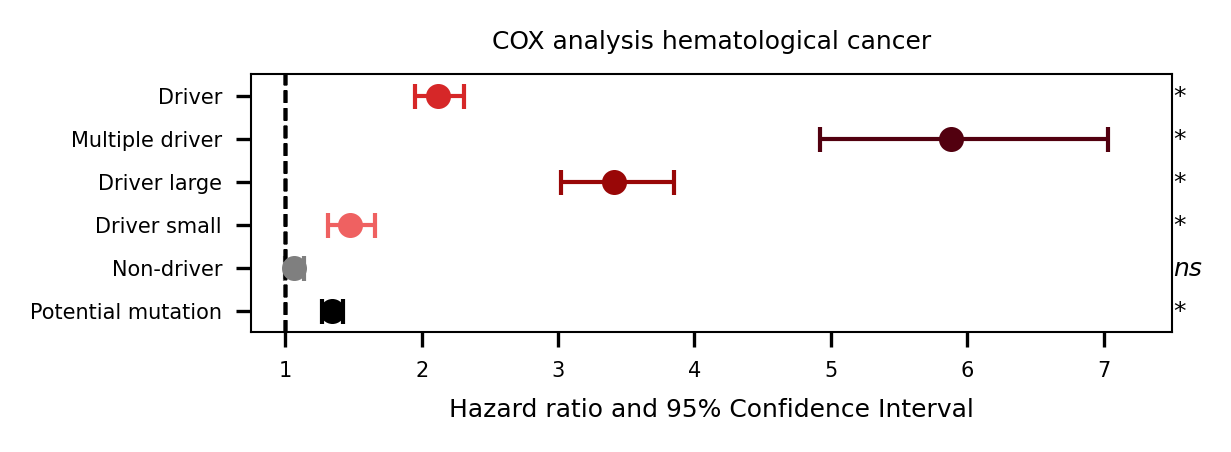

In [151]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.3, 1.5), dpi=300)
xlimit = 7.5
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['hazard_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['hazard_ratio']]]
    if row['variable'].endswith('_driver'):
        plt.errorbar(x=[row['hazard_ratio']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['variable'].endswith('multiple'):
        plt.errorbar(x=[row['hazard_ratio']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, '*', style='italic', size=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, 'ns', style='italic', size=6)

        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Hazard ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('COX analysis hematological cancer', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.75, xlimit])
ax.set_ylim(-.5, ylimit+.5)
# ax.tick_params(axis='x', labelsize=6)
# ax.tick_params(axis='y', labelsize=6)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

### Post-myeloid cancer Kaplan Meier

In [45]:
# Remove cases with prior hematological cancer
variables = ukb200K_ch_cancer.copy().reset_index(drop=True)
variables = variables[variables['var_HNALL_pre']==0].reset_index(drop=True)
len(variables)

467202

In [46]:
#Calculate de date of cancer from those cases with Nan
# date of last follow-up minus age( which is the sampling date)
import math
from datetime import timedelta

years = []
for n, x in enumerate(variables['var_MM_years']):
    if math.isnan(x):
        if variables.loc[n, 'Death_status']== 0:
            year = maxdate-pd.to_datetime(variables.loc[n,'53-0.0'], format='%Y-%m-%d')
            years.append(year/np.timedelta64(1,'Y'))
        elif variables.loc[n, 'Death_status']== 1:
            year = variables.loc[n,'40007-0.0']-variables.loc[n,'age_recruitment_x']
            years.append(year)
    else:
        years.append(x)
                
variables['years'] = years
variables = variables[variables['years'] >= 0]
len(variables)

467202

In [47]:
# 1. Calculate 3% of the 
p = np.percentile(variables['years'], 97)
# variables = variables[variables['years']<p]
variables['years'] = variables['years'].apply(lambda x: p if x>p else x)
len(variables)

467202

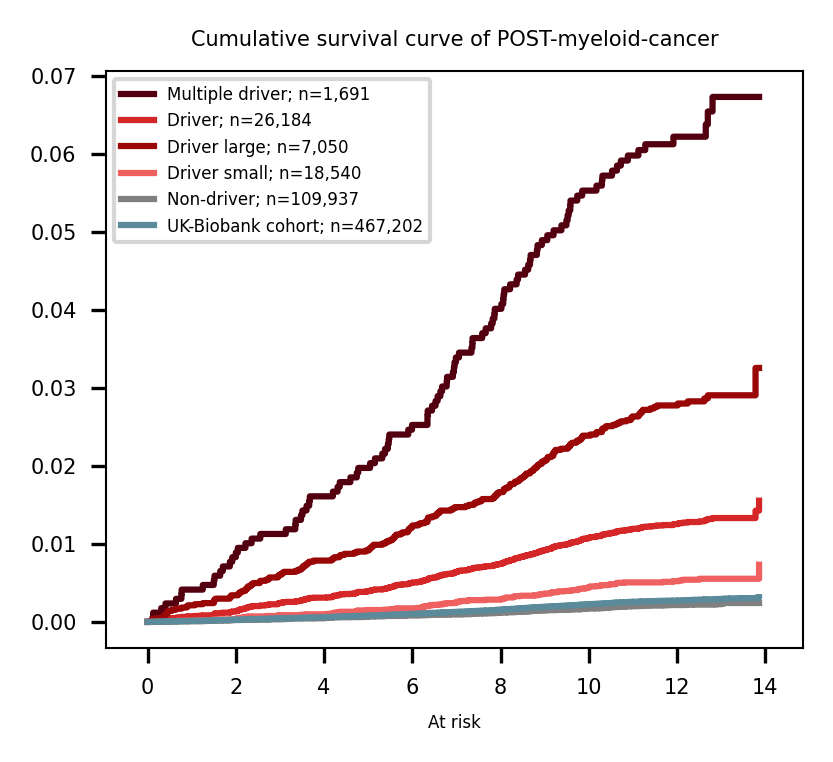

In [156]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import pairwise_logrank_test
import matplotlib
from lifelines.statistics import multivariate_logrank_test
from matplotlib.offsetbox import AnchoredText
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
plt.figure(figsize=(3, 2.5))
ax = plt.subplot(111)

# Define variables of time and event
T = variables['years']
E = variables['var_MM_post']

# Define different types
mult = (variables["CH_driver"] == 1) & (variables["CH_nonDriver"] == 0) & (variables["CH_driver_multiple"] == 1)
dr = (variables["CH_driver"] == 1) & (variables["CH_nonDriver"] == 0)
bg = (variables["CH_driver_small"] == 0) & (variables["CH_driver_big"] == 1) & (variables["CH_nonDriver"] == 0)
sm = (variables["CH_driver_small"] == 1) & (variables["CH_driver_big"] == 0) & (variables["CH_nonDriver"] == 0)
pa = (variables["CH_nonDriver"] == 1) & (variables["CH_driver"] == 0)

Emulti = len(variables[mult & (variables["var_MM_post"] == 1)])
Edriv = len(variables[dr & (variables["var_MM_post"] == 1)])
Ebig = len(variables[bg & (variables["var_MM_post"] == 1)])
Esmall = len(variables[sm & (variables["var_MM_post"] == 1)])
Epass = len(variables[pa & (variables["var_MM_post"] == 1)])
Eall = len(variables[variables["var_MM_post"] == 1])

kmf.fit(durations = T[mult], event_observed = E[mult], label = "Multiple driver; n="+f'{len(E[mult]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#52000F')

kmf.fit(durations = T[dr], event_observed = E[dr], label = "Driver; n="+f'{len(E[dr]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#D62728')

kmf.fit(durations = T[bg], event_observed = E[bg], label = "Driver large; n="+f'{len(E[bg]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#990707')

kmf.fit(durations = T[sm], event_observed = E[sm], label = "Driver small; n="+f'{len(E[sm]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='#EF6161')

kmf.fit(durations = T[pa], event_observed = E[pa], label = "Non-driver; n="+f'{len(E[pa]):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, color='grey')

kmf.fit(durations = T, event_observed = E, label = "UK-Biobank cohort; n="+f'{len(E):,}')
kmf.plot_cumulative_density(ax = ax, ci_show=False, at_risk_counts = False, color='#5B8A9A')

plt.title("Cumulative survival curve of POST-myeloid-cancer", fontsize = 5)
plt.xlim([-0.95, p+1])
ax.set_xlabel("At risk", fontsize = 4)
matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4)
ax.legend(prop={'size': 4})

p_dr_pa = logrank_test(T[dr], T[pa], event_observed_A=E[dr], event_observed_B=E[pa])
p_dr_all = logrank_test(T[dr], T, event_observed_A=E[dr], event_observed_B=E)
p_pa_all = logrank_test(T[pa], T, event_observed_A=E[pa], event_observed_B=E)

plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

In [157]:
#perform cox
import statsmodels.stats.multitest as mtc
from lifelines import CoxPHFitter
#exclude cases with NaN in some variables
variables = variables[variables['PC1'].notna()]

def cox_reg(target, lista, penalizer=0):
        
    #we have exclude pre hematological cases
    CH_driver_multiple_matrix = variables[((variables['CH_nonDriver']==0) & (variables['CH_driver_multiple']==1)) | (variables['CH_potential'] == 0)]
    CH_driver_matrix = variables[(variables['CH_nonDriver']==0)]
    CH_driver_big = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = variables[variables['CH_driver']==0]
    
    
    variable = []
    hr = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith('multiple'):
            model = CH_driver_multiple_matrix[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter(penalizer=penalizer)
            cph.fit(model, 'years', target)
        elif gene.endswith(('_driver')):
            model = CH_driver_matrix[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter(penalizer=penalizer)
            cph.fit(model, 'years', target)
        elif gene.endswith('big'):
            model = CH_driver_big[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter(penalizer=penalizer)
            cph.fit(model, 'years', target)  
        elif gene.endswith('small'):
            model = CH_driver_small[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter(penalizer=penalizer)
            cph.fit(model, 'years', target)  
        elif gene.endswith('nonDriver'):
            model = CH_passengers_matrix[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter(penalizer=penalizer)
            cph.fit(model, 'years', target) 
        elif gene.endswith('potential'):
            model = variables[['years', target, gene, 'age_recruitment_x','sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Smoking_2']]
            cph = CoxPHFitter(penalizer=penalizer)
            cph.fit(model, 'years', target)
        else:
            print('No matrix defined')
            
        variable.append(cph.params_.index.tolist()[0])
        hr.append(cph.hazard_ratios_.tolist()[0])
        cilow.append(np.exp(cph.confidence_intervals_.iloc[:,0]).tolist()[0])
        ciup.append(np.exp(cph.confidence_intervals_.iloc[:,1]).tolist()[0])
        pval.append(cph.summary.p.tolist()[0])
    varlist = pd.DataFrame(list(zip(variable, hr, cilow, ciup, pval)), columns = ['variable','hazard_ratio', 'confint_1st', 'confint_2nd', 'pval'])
    return(varlist)

In [158]:
from lifelines import CoxPHFitter
variables = variables[variables['PC1'].notna()]
variables = variables[variables['Smoking_2'].notna()]
varlist = cox_reg('var_MM_post',['CH_driver', 'CH_driver_multiple', 'CH_driver_big', 'CH_driver_small', 'CH_nonDriver', 'CH_potential'], 0.002)
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

,variable,hazard_ratio,confint_1st,confint_2nd,pval,q_value,sig
0,CH_driver,4.326634,3.801630,4.924140,3.977267e-109,7.954533e-109,sig
1,CH_driver_multiple,26.439763,21.289130,32.836525,7.415079e-193,4.449047e-192,sig
2,CH_driver_big,10.741798,9.096408,12.684812,2.325286e-172,6.975859e-172,sig
3,CH_driver_small,1.925185,1.582405,2.342219,5.848757e-11,7.018509e-11,sig
4,CH_nonDriver,1.087570,0.975637,1.212345,1.298054e-01,1.298054e-01,ns
5,CH_potential,1.752803,1.608148,1.910470,2.395007e-37,3.592511e-37,sig


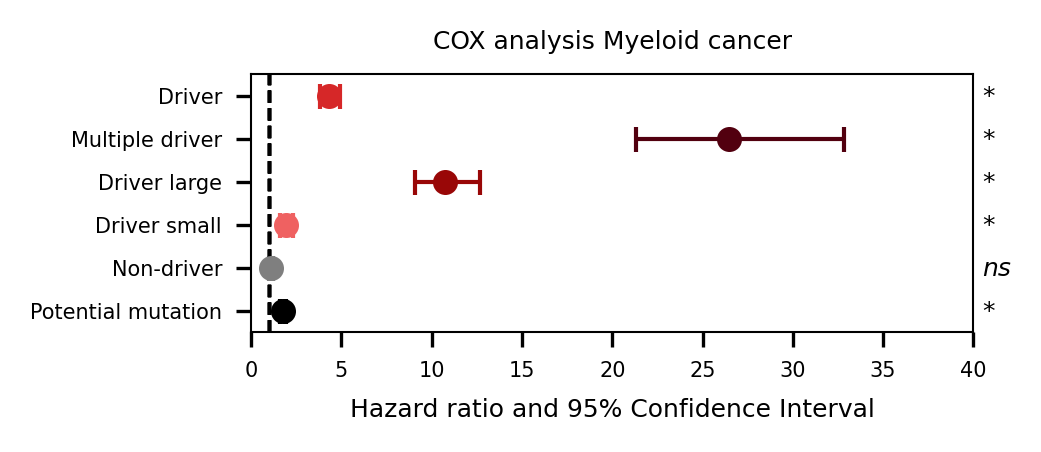

In [160]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.1, 1.5), dpi=300)
xlimit = 40
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['hazard_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['hazard_ratio']]]
    if row['variable'].endswith('_driver'):
        plt.errorbar(x=[row['hazard_ratio']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['variable']:
        plt.errorbar(x=[row['hazard_ratio']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['variable'].endswith('multiple'):
        plt.errorbar(x=[row['hazard_ratio']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.5, ylimit-idx-0.2, '*', style='italic', size=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.5, ylimit-idx-0.2, 'ns', style='italic', size=6)

        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Hazard ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('COX analysis Myeloid cancer', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0, xlimit])
ax.set_ylim(-.5, ylimit+.5)
# ax.tick_params(axis='x', labelsize=6)
# ax.tick_params(axis='y', labelsize=6)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 2.3 Study associations gene by gene

In [103]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2', 'U2AF1','GNAS', 'IDH2', 'MDM4']

In [104]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'CHEK2':
        matri = mat[(mat['ASXL1_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'MDM4':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    elif gene == 'DDR':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['U2AF1_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    elif gene == 'splicing':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    elif gene == 'chromatin':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['U2AF1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TP53_potential']==0)]
    return(matri)

In [105]:
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf
from tqdm import tqdm

In [48]:
#Remove cases with prior hemathological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_logistic)

467202

In [107]:
## Version 1 Loop of logistic regressions
variables_genes = [
    'DNMT3A_driver','DNMT3A_driver_big', 'DNMT3A_passenger',
    'TET2_driver','TET2_driver_big', 'TET2_passenger',
    'ASXL1_driver', 'ASXL1_driver_big', 'ASXL1_passenger',
    'CHEK2_driver', 'CHEK2_driver_big', 'CHEK2_passenger',
    'TP53_driver','TP53_driver_big', 'TP53_passenger',
    'PPM1D_driver','PPM1D_driver_big', 'PPM1D_passenger',
    'SF3B1_driver','SF3B1_driver_big', 'SF3B1_passenger',
    'SRSF2_driver','SRSF2_driver_big', 'SRSF2_passenger',
    'U2AF1_driver','U2AF1_driver_big', 'U2AF1_passenger',
    'GNAS_driver','GNAS_driver_big', 'GNAS_passenger',
    'IDH2_driver','IDH2_driver_big', 'IDH2_passenger',
    'MDM4_driver','MDM4_driver_big', 'MDM4_passenger',
    'chromatin_gene_driver', 'chromatin_gene_driver_big', 'chromatin_gene_passenger',
    'DDR_gene_driver', 'DDR_gene_driver_big', 'DDR_gene_passenger',
    'splicing_gene_driver', 'splicing_gene_driver_big', 'splicing_gene_passenger']

def log_reg_multi(target):
    
    ## Ignore warning
    import warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    warnings.simplefilter('ignore', ConvergenceWarning)
    warnings.simplefilter('ignore', RuntimeWarning)

    ## Loop of logistic regressions
    gene_results = []
    for gene in variables_genes:
        gen = gene.split('_')[0]
        mat_gene = gene_matrix(ukb200K_ch_cancer_logistic, gen)
        
        #set matrixes
        if gene.endswith(('driver')):
            mat_gene = mat_gene[mat_gene['CH_nonDriver'] == 0]
        elif gene.endswith('big'):
            mat_gene = mat_gene[(mat_gene['CH_nonDriver'] == 0) & (mat_gene['CH_driver_small'] == 0)]
        elif gene.endswith(('passenger', 'passengers')):
            mat_gene = mat_gene[mat_gene['CH_driver'] == 0]
        else:
            print('no matrix assaigned')
        
        ## Get number of mutated samples and percentage
        num_mut = len(mat_gene[(mat_gene[gene.replace('_big', '')] == 1)])
        num_mut_can = len(mat_gene[(mat_gene[gene.replace('_big', '')] == 1) & (mat_gene[target] == 1)])
        if num_mut > 0:
            per_mut = round(num_mut_can / num_mut * 100, 2)
        else:
            per_mut = 0

        formula= target+' ~ 1 + age_recruitment_x + '+gene.replace('_big', '')+'+ sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2'


        ## Exception to avoid LinAlgError
        try:
            
            # Logistic regression
            model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
            # Get parameters from the logistic regression
            p = model.pvalues[2]
    
            odds = np.exp(model.params[2])
            conint1 = np.exp(model.conf_int().iloc[2,0])
            conint2 = np.exp(model.conf_int().iloc[2,1])
            prsquared = model.prsquared
            
            results = [gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
        except np.linalg.LinAlgError as err:
            print("LinAlgError:")
            print(gene, num_mut, num_mut_can, per_mut)
            results = [gene, num_mut, num_mut_can, per_mut, np.nan, np.nan, np.nan, np.nan, np.nan]
            
    
        ## Append results    
        gene_results.append(results)
    
    # Get dataframe
    output = pd.DataFrame(gene_results, columns=["gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
    output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
    output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
    output = output[["gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]
    return(output)

### cancer_pre association per gene

In [108]:
## Loop of logistic regressions
variables_genes = [
    'DNMT3A_driver','DNMT3A_driver_big', 'DNMT3A_passenger',
    'TET2_driver','TET2_driver_big', 'TET2_passenger',
    'ASXL1_driver', 'ASXL1_driver_big', 'ASXL1_passenger',
    'CHEK2_driver', 'CHEK2_driver_big', 'CHEK2_passenger',
    'TP53_driver','TP53_driver_big', 'TP53_passenger',
    'PPM1D_driver','PPM1D_driver_big', 'PPM1D_passenger',
    'SF3B1_driver','SF3B1_driver_big', 'SF3B1_passenger',
    'SRSF2_driver','SRSF2_driver_big', 'SRSF2_passenger',
    'U2AF1_driver','U2AF1_driver_big', 'U2AF1_passenger',
    'GNAS_driver','GNAS_driver_big', 'GNAS_passenger',
    'IDH2_driver','IDH2_driver_big', 'IDH2_passenger',
    'MDM4_driver','MDM4_driver_big', 'MDM4_passenger',
    'chromatin_gene_driver', 'chromatin_gene_driver_big', 'chromatin_gene_passenger',
    'DDR_gene_driver', 'DDR_gene_driver_big', 'DDR_gene_passenger',
    'splicing_gene_driver', 'splicing_gene_driver_big', 'splicing_gene_passenger']

gene_results = []
for gene in tqdm(variables_genes):
    gen = gene.split('_')[0]
    mat_gene = gene_matrix(ukb200K_ch_cancer_logistic, gen)
    #set matrixes
    if gene.endswith(('driver')):
        mat_gene = mat_gene[mat_gene['CH_nonDriver'] == 0]
    elif gene.endswith('big'):
        mat_gene = mat_gene[(mat_gene['CH_nonDriver'] == 0) & (mat_gene['CH_driver_small'] == 0)]
    elif gene.endswith(('passenger', 'passengers')):
        mat_gene = mat_gene[mat_gene['CH_driver'] == 0]
    else:
        print('no matrix assaigned')
    
    
    ## Get number of mutated samples and percentage
    num_mut = len(mat_gene[(mat_gene['cancer1_pre'] == 1)])
    num_mut_can = len(mat_gene[(mat_gene['cancer1_pre'] == 1) & (mat_gene[gene.replace('_big', '')] == 1)])
    if num_mut > 0:
        per_mut = round(num_mut_can / num_mut * 100, 2)
    else:
        per_mut = 0
   
    formula= gene.replace('_big', '')+' ~ 1 + age_recruitment_x + cancer1_pre + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2'
        
    try:
            
        # Logistic regression
        model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
        # Get parameters from the logistic regression
        p = model.pvalues[2]
        odds = np.exp(model.params[2])
        conint1 = np.exp(model.conf_int().iloc[2,0])
        conint2 = np.exp(model.conf_int().iloc[2,1])
        prsquared = model.prsquared
            
        results = [gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(gene, num_mut, num_mut_can, per_mut, message)
        results = [gene, num_mut, num_mut_can, per_mut, np.nan ,np.nan, np.nan, np.nan, np.nan]
            
    
    ## Append results    
    gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
output = output[["gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]

output

100%|██████████| 45/45 [01:33<00:00,  2.08s/it]


,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,DNMT3A_driver,25241,1308,5.18,0.022884,0.147112,not significant,1.071154,1.009573,1.136491,0.018193
1,DNMT3A_driver_big,24251,318,1.31,0.015685,0.133369,not significant,1.156847,1.027891,1.301982,0.021603
2,DNMT3A_passenger,24582,649,2.64,0.379924,0.657561,not significant,0.963871,0.887864,1.046386,0.001484
3,TET2_driver,24402,469,1.92,0.480896,0.745680,not significant,1.035518,0.939744,1.141054,0.008761
4,TET2_driver_big,24070,137,0.57,0.628622,0.794042,not significant,0.957063,0.801136,1.143339,0.014578
...,...,...,...,...,...,...,...,...,...,...,...
40,DDR_gene_driver_big,24058,125,0.52,0.008139,0.122078,not significant,1.288921,1.068039,1.555484,0.005660
41,DDR_gene_passenger,25486,1553,6.09,0.280381,0.625252,not significant,1.030268,0.975970,1.087587,0.002508
42,splicing_gene_driver,24009,76,0.32,0.556053,0.765761,not significant,0.930948,0.733620,1.181353,0.027639
43,splicing_gene_driver_big,23963,30,0.13,0.794439,0.893744,not significant,1.051676,0.719910,1.536333,0.045763


In [109]:
output['significant?'] = ['significant' if pval <= 0.1 else 'not significant' for pval in output.q_value]
output = output[["gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]

output

,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,DNMT3A_driver,25241,1308,5.18,0.022884,0.147112,not significant,1.071154,1.009573,1.136491,0.018193
1,DNMT3A_driver_big,24251,318,1.31,0.015685,0.133369,not significant,1.156847,1.027891,1.301982,0.021603
2,DNMT3A_passenger,24582,649,2.64,0.379924,0.657561,not significant,0.963871,0.887864,1.046386,0.001484
3,TET2_driver,24402,469,1.92,0.480896,0.745680,not significant,1.035518,0.939744,1.141054,0.008761
4,TET2_driver_big,24070,137,0.57,0.628622,0.794042,not significant,0.957063,0.801136,1.143339,0.014578
...,...,...,...,...,...,...,...,...,...,...,...
40,DDR_gene_driver_big,24058,125,0.52,0.008139,0.122078,not significant,1.288921,1.068039,1.555484,0.005660
41,DDR_gene_passenger,25486,1553,6.09,0.280381,0.625252,not significant,1.030268,0.975970,1.087587,0.002508
42,splicing_gene_driver,24009,76,0.32,0.556053,0.765761,not significant,0.930948,0.733620,1.181353,0.027639
43,splicing_gene_driver_big,23963,30,0.13,0.794439,0.893744,not significant,1.051676,0.719910,1.536333,0.045763


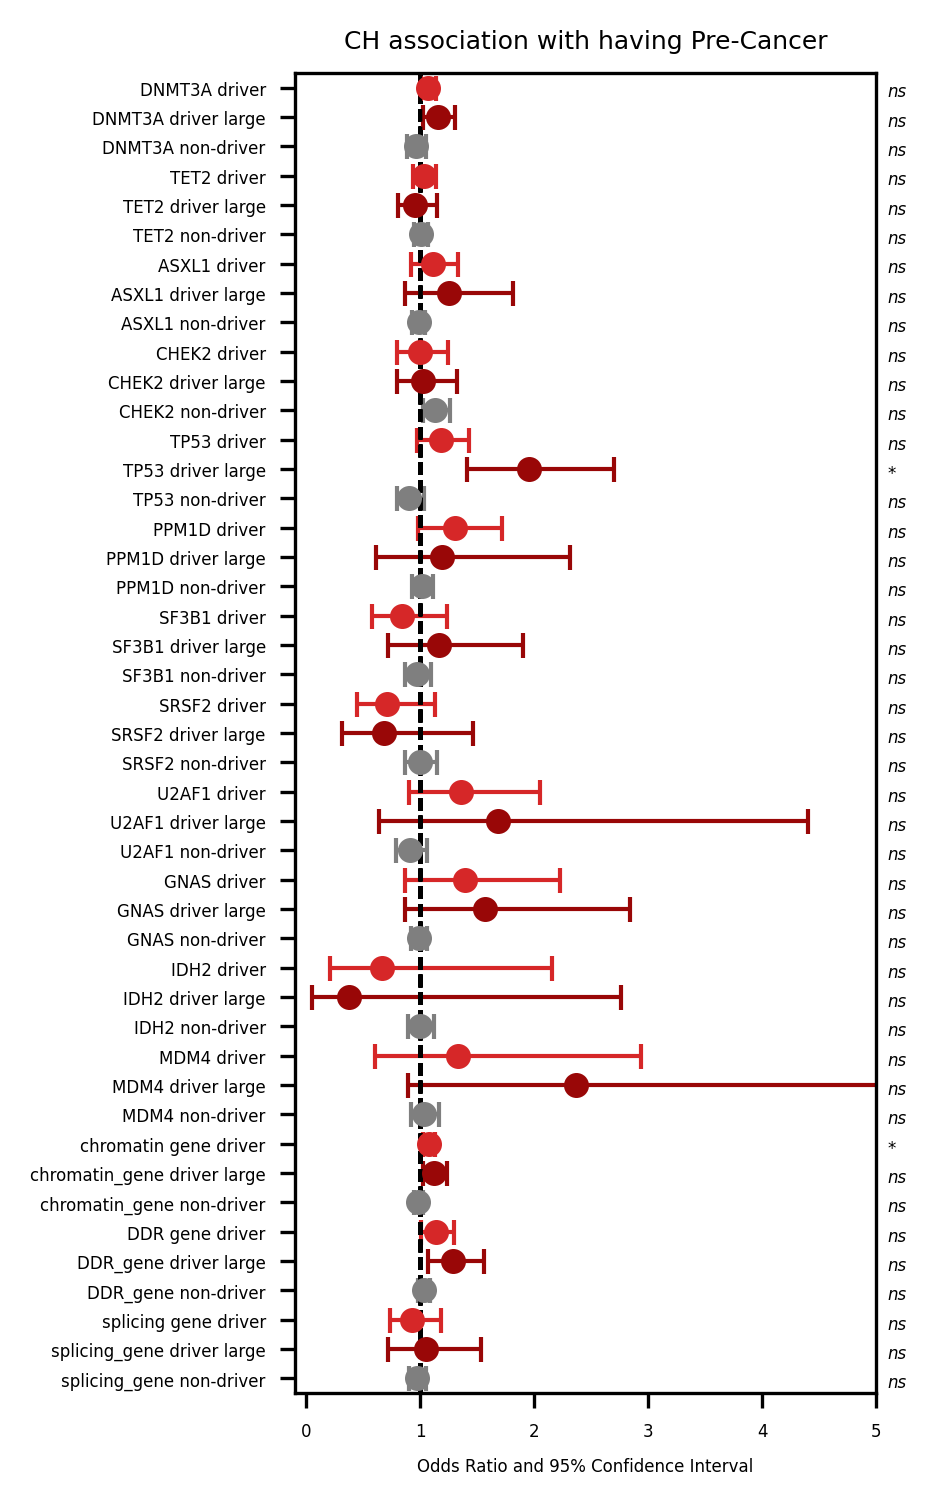

In [113]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 5))
xlimit = 5
ylimit = len(output)-1

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
   
    if row['gene'].endswith('driver'):
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('_', ' ')], xerr=ci,
                 ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:red", mec="tab:red")

    elif 'pas' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('_passenger', ' non-driver')], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")

    elif 'big' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('_driver_big', ' driver large')], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")

    if row['significant?'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.1, ylimit-idx-0.3, '*', style='italic', size=4)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.1, ylimit-idx-0.3, 'ns', style='italic', size=4)
        

        plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=4)
ax.set_title('CH association with having Pre-Cancer', fontdict={'size':6})
plt.tight_layout()
plt.xlim([-0.1, xlimit])
ax.set_ylim(-.5, ylimit+.5)
#plt.savefig('precancer_gene.png', dpi=400,  bbox_inches='tight')
plt.show()

### All Logistic regression (post-HC)

In [69]:
#Remove cases with prior hemathological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_logistic)

467202

In [70]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'CHEK2':
        matri = mat[(mat['ASXL1_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'MDM4':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    elif gene == 'DDR':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['U2AF1_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    elif gene == 'splicing':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    elif gene == 'chromatin':
        matri = mat[(mat['CHEK2_potential']==0) &\
                 (mat['U2AF1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TP53_potential']==0)]
    elif gene == 'CH':
        matri = mat
    return matri

In [71]:
from tqdm import tqdm

## Ignore warning
variables = ['var_HNALL_post',
 'var_MM_post',
 'var_MPN_post',
 'var_MDS_post',
 'var_CMML_post',
 'var_AML_post',
 'var_LL_post',
 'var_Lymphoma_post',
 'var_Myeloma_post']

variables_genes = ['CH_driver',
 'CH_driver_big',
 'CH_driver_small',           
 'CH_nonDriver',
 'ASXL1_driver',
 'ASXL1_driver_big',
 'CHEK2_driver',
 'CHEK2_driver_big',
 'DNMT3A_driver',
 'DNMT3A_driver_big',
 'GNAS_driver',
 'GNAS_driver_big',
 'IDH2_driver',
 'IDH2_driver_big',
 'MDM4_driver',
 'MDM4_driver_big',
 'PPM1D_driver',
 'PPM1D_driver_big',
 'SF3B1_driver',
 'SF3B1_driver_big',
 'SRSF2_driver',
 'SRSF2_driver_big',
 'TET2_driver',
 'TET2_driver_big',
 'TP53_driver',
 'TP53_driver_big',
 'U2AF1_driver',
 'U2AF1_driver_big',
 'chromatin_gene_driver',
 'chromatin_gene_driver_big',
 'DDR_gene_driver',
 'DDR_gene_driver_big',
 'splicing_gene_driver',
 'splicing_gene_driver_big']

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

gene_results = []

for target in tqdm(variables):
    ## Hemathological pre have been previously removed
#     ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logistic[ukb200K_ch_cvd_logistic[target.replace('_post', '_pre')]==0]
    ## Loop of logistic regressions
    
    for gene in tqdm(variables_genes):
        gen = gene.split('_')[0]
        mat_genes = gene_matrix(ukb200K_ch_cancer_logistic, gen)
        
        #set matrixes
        if gene.endswith(('multiple')):
            mat_gene = mat_genes[((mat_genes['CH_nonDriver']==0) & (mat_genes['CH_driver_multiple']==1)) | (mat_genes['CH_potential'] == 0)]
        elif gene.endswith(('_driver')):
            mat_gene = mat_genes[mat_genes['CH_nonDriver'] == 0]
        elif gene.endswith(('big')):
            mat_gene = mat_genes[(mat_genes['CH_nonDriver'] == 0) & (mat_genes['CH_driver_small'] == 0)]
        elif gene.endswith(('small')):
            mat_gene = mat_genes[(mat_genes['CH_nonDriver'] == 0) & (mat_genes['CH_driver_big'] == 0)]
        elif gene.endswith(('nonDriver', 'passenger')):
            mat_gene = mat_genes[mat_genes['CH_driver'] == 0]
        elif gene.endswith(('potential')):
            mat_gene = mat_genes
        else:
            print('no matrix assaigned')
            
    ## Get number of mutated samples and percentage
        num_mut = len(mat_gene[(mat_gene[gene.replace('_big', '')] == 1)])
        num_mut_can = len(mat_gene[(mat_gene[gene.replace('_big', '')] == 1) & (mat_gene[target] == 1)])
        if num_mut > 0:
            per_mut = round(num_mut_can / num_mut * 100, 2)
        else:
            per_mut = 0
    
        ## Logistic regression
        formula = target+' ~ 1 + age_recruitment_x + '+gene.replace('_big', '')+' + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2'

        ## Exception to avoid LinAlgError
        try:
            
            # Logistic regression
            model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
            # Get parameters from the logistic regression
            p = model.pvalues[2]
            odds = np.exp(model.params[2])
            conint1 = np.exp(model.conf_int().iloc[2,0])
            conint2 = np.exp(model.conf_int().iloc[2,1])
            prsquared = model.prsquared
            
            results = [target.split('_')[1]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
        except Exception as ex:
            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            message = template.format(type(ex).__name__, ex.args)
            print(target, gene, num_mut, num_mut_can, per_mut, message)
            results = [target.split('_')[1]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, 1, np.nan, np.nan, np.nan, np.nan]
            
    
        ## Append results    
        gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
output = output[["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]
output

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                             | 15/34 [01:21<02:09,  6.80s/it]

var_MM_post MDM4_driver 68 0 0.0 An exception of type LinAlgError occurred. Arguments:
('Singular matrix',)



 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 14/34 [01:29<02:10,  6.52s/it]

var_MDS_post IDH2_driver_big 26 0 0.0 An exception of type LinAlgError occurred. Arguments:
('Singular matrix',)



 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 19/34 [02:08<01:40,  6.67s/it]

var_CMML_post SF3B1_driver 406 0 0.0 An exception of type LinAlgError occurred. Arguments:
('Singular matrix',)



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 31/34 [03:27<00:18,  6.29s/it]

var_CMML_post DDR_gene_driver 3021 0 0.0 An exception of type LinAlgError occurred. Arguments:
('Singular matrix',)



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 32/34 [03:32<00:12,  6.00s/it]

var_CMML_post DDR_gene_driver_big 1296 0 0.0 An exception of type LinAlgError occurred. Arguments:
('Singular matrix',)



 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 12/34 [01:05<02:06,  5.75s/it]

var_AML_post GNAS_driver_big 97 0 0.0 An exception of type LinAlgError occurred. Arguments:
('Singular matrix',)



 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 18/34 [01:39<01:34,  5.88s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [29:11<00:00, 194.60s/it]


,variable,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,HNALL (CH_driver),CH_driver,26184,655,2.50,1.430168e-66,2.431285e-65,significant,2.131076,1.955385,2.322551,0.038114
1,HNALL (CH_driver_big),CH_driver_big,7050,287,4.07,6.991080e-84,2.139270e-82,significant,3.429941,3.028456,3.884651,0.039542
2,HNALL (CH_driver_small),CH_driver_small,18540,321,1.73,4.104915e-11,1.720690e-10,significant,1.482659,1.319015,1.666604,0.030411
3,HNALL (CH_nonDriver),CH_nonDriver,109937,1181,1.07,6.047958e-02,1.135384e-01,not significant,1.066780,0.997157,1.141263,0.029537
4,HNALL (ASXL1_driver),ASXL1_driver,1401,29,2.07,1.444089e-02,3.006062e-02,significant,1.601001,1.098047,2.334329,0.030156
...,...,...,...,...,...,...,...,...,...,...,...,...
301,Myeloma (chromatin_gene_driver_big),chromatin_gene_driver_big,5174,11,0.21,8.274043e-01,1.000000e+00,not significant,0.935629,0.514451,1.701624,0.030347
302,Myeloma (DDR_gene_driver),DDR_gene_driver,3021,8,0.26,4.795716e-01,7.158484e-01,not significant,1.286889,0.639535,2.589511,0.029777
303,Myeloma (DDR_gene_driver_big),DDR_gene_driver_big,1296,3,0.23,7.966361e-01,1.000000e+00,not significant,1.161191,0.372631,3.618497,0.030491
304,Myeloma (splicing_gene_driver),splicing_gene_driver,954,4,0.42,7.082612e-01,9.806693e-01,not significant,1.242610,0.398311,3.876567,0.030521


In [72]:
# Prepare matrix for heatmap
matrix = []
for x in variables:
    var = x.split('_')[1]
    odds = output[output['variable'].str.startswith(var)]['odds_ratio']
    gene = output[output['variable'].str.startswith(var)]['gene'].tolist()
    pval = output[output['variable'].str.startswith(var)]['q_value']
    pval_name = [x+'_pval' for x in gene]
    matrix.append([var]+odds.tolist()+pval.tolist())
matrix = pd.DataFrame(matrix, columns=['var']+gene+pval_name)
matrix

,var,CH_driver,CH_driver_big,CH_driver_small,CH_nonDriver,ASXL1_driver,ASXL1_driver_big,CHEK2_driver,CHEK2_driver_big,DNMT3A_driver,DNMT3A_driver_big,GNAS_driver,GNAS_driver_big,IDH2_driver,IDH2_driver_big,MDM4_driver,MDM4_driver_big,PPM1D_driver,PPM1D_driver_big,SF3B1_driver,SF3B1_driver_big,SRSF2_driver,SRSF2_driver_big,TET2_driver,TET2_driver_big,TP53_driver,TP53_driver_big,U2AF1_driver,U2AF1_driver_big,chromatin_gene_driver,chromatin_gene_driver_big,DDR_gene_driver,DDR_gene_driver_big,splicing_gene_driver,splicing_gene_driver_big,CH_driver_pval,CH_driver_big_pval,CH_driver_small_pval,CH_nonDriver_pval,ASXL1_driver_pval,ASXL1_driver_big_pval,CHEK2_driver_pval,CHEK2_driver_big_pval,DNMT3A_driver_pval,DNMT3A_driver_big_pval,GNAS_driver_pval,GNAS_driver_big_pval,IDH2_driver_pval,IDH2_driver_big_pval,MDM4_driver_pval,MDM4_driver_big_pval,PPM1D_driver_pval,PPM1D_driver_big_pval,SF3B1_driver_pval,SF3B1_driver_big_pval,SRSF2_driver_pval,SRSF2_driver_big_pval,TET2_driver_pval,TET2_driver_big_pval,TP53_driver_pval,TP53_driver_big_pval,U2AF1_driver_pval,U2AF1_driver_big_pval,chromatin_gene_driver_pval,chromatin_gene_driver_big_pval,DDR_gene_driver_pval,DDR_gene_driver_big_pval,splicing_gene_driver_pval,splicing_gene_driver_big_pval
0,HNALL,2.131076,3.429941,1.482659,1.066780,1.601001e+00,2.541540e+00,1.088003,1.374267e+00,1.465137,1.681633,9.367407e-01,1.554724,1.625653e+01,2.657134e+01,1.285763e+00,3.389319e+00,1.274885e+00,1.415613e+00,3.378738,5.140000e+00,12.813054,2.725491e+01,2.164735,3.342245,2.182396e+00,3.552760,5.680631,21.854451,1.686311,2.402278,1.635878,1.952169,7.106547,13.649676,2.431285e-65,2.139270e-82,1.720690e-10,0.113538,0.030061,5.835866e-03,1.000000,0.444986,7.263570e-08,1.717485e-04,1.000000,0.787111,4.787708e-13,1.478988e-12,1.000000,0.384726,0.711278,0.893246,3.419501e-06,1.883249e-07,2.040809e-55,2.754313e-54,1.417045e-17,1.040497e-20,0.000078,5.548240e-05,3.874432e-11,6.287568e-14,2.041938e-22,6.486104e-24,8.718989e-04,1.551242e-03,9.608659e-62,2.431285e-65
1,MM,5.739636,12.377238,2.436509,1.178765,3.347667e+00,9.860748e+00,1.822815,1.855742e+00,2.752936,5.489695,2.611953e+00,4.375120,7.551761e+01,1.401882e+02,NaN,1.122673e-06,3.090999e+00,3.900864e+00,9.496680,1.574181e+01,60.474685,1.372640e+02,4.754833,9.129776,3.907277e+00,7.806488,17.829843,84.590439,3.448228,7.297073,3.222773,3.498560,28.612517,59.861627,1.551606e-134,4.054300e-189,4.665555e-15,0.065168,0.000214,1.134660e-09,0.384726,0.454605,8.549697e-17,1.937971e-22,0.529607,0.246764,5.886011e-27,9.730040e-27,1.000000,1.000000,0.051002,0.300503,1.735040e-10,7.183768e-12,3.064519e-121,5.519553e-109,2.131076e-27,5.638505e-34,0.000060,1.796567e-05,9.345353e-18,2.392791e-23,1.226947e-41,7.153325e-62,9.605581e-07,5.385528e-04,6.919077e-128,2.535230e-128
2,MPN,3.465627,7.474474,1.768933,1.040490,3.406189e+00,8.517998e+00,1.887693,1.290212e+00,1.828497,3.117128,5.677478e+00,9.629837,3.690710e+01,3.370054e+01,9.140508e-04,6.768173e-07,5.889788e-07,2.879354e-05,9.380491,1.499715e+01,26.031301,5.452778e+01,3.626692,6.288835,1.076315e-07,0.030273,7.864842,23.441672,2.471317,4.599746,0.681680,0.814561,15.446398,29.589447,5.406243e-24,2.234402e-40,4.714988e-03,0.998458,0.014778,6.518199e-04,0.571242,1.000000,7.624691e-03,1.065652e-03,0.153311,0.049949,2.211877e-06,1.458682e-03,1.000000,1.000000,1.000000,1.000000,3.000708e-05,1.205421e-05,3.854056e-20,1.238651e-22,1.027365e-07,1.027791e-08,1.000000,9.984580e-01,8.545743e-03,4.715247e-03,5.470723e-09,1.808338e-12,8.507309e-01,1.000000e+00,9.374272e-25,7.444263e-26
3,MDS,6.512883,14.853257,2.153265,1.370740,5.506728e+00,2.021846e+01,1.842978,2.455628e+00,2.223183,6.260676,7.472587e-05,0.000058,6.140583e-09,NaN,5.589293e-149,2.647891e-04,1.055410e+01,1.233518e+01,18.697734,3.149735e+01,69.768346,1.591540e+02,3.187667,3.829645,6.169997e+00,24.428847,36.003176,127.899019,2.831234,6.778747,6.226758,9.053484,43.251386,91.687834,2.380632e-43,1.975325e-66,2.073782e-03,0.069081,0.000513,3.761311e-10,0.791071,0.571242,4.602

In [73]:
[x.replace('big', 'large').replace('_', ' ').replace('nonDriver', 'non-driver') for x in variables_genes]

['CH driver',
 'CH driver large',
 'CH driver small',
 'CH non-driver',
 'ASXL1 driver',
 'ASXL1 driver large',
 'CHEK2 driver',
 'CHEK2 driver large',
 'DNMT3A driver',
 'DNMT3A driver large',
 'GNAS driver',
 'GNAS driver large',
 'IDH2 driver',
 'IDH2 driver large',
 'MDM4 driver',
 'MDM4 driver large',
 'PPM1D driver',
 'PPM1D driver large',
 'SF3B1 driver',
 'SF3B1 driver large',
 'SRSF2 driver',
 'SRSF2 driver large',
 'TET2 driver',
 'TET2 driver large',
 'TP53 driver',
 'TP53 driver large',
 'U2AF1 driver',
 'U2AF1 driver large',
 'chromatin gene driver',
 'chromatin gene driver large',
 'DDR gene driver',
 'DDR gene driver large',
 'splicing gene driver',
 'splicing gene driver large']

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap
# from matplotlib.colors import TwoSlopeNorm
import cmasher as cmr

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 5), dpi=300)

for x in pval_name:
    matrix[x+'-sig'] = ['**' if float(pval) <= 0.05 else '*' if float(pval) <= 0.1 else '' for pval in matrix[x]]

my_cmap = mpl.cm.coolwarm
bounds = [0.125, 0.25, 0.5, 1, 2, 4, 8]
my_norm = BoundaryNorm(bounds, my_cmap.N)

ax = sns.heatmap(np.transpose(matrix.loc[:,gene]),
                 annot=np.transpose(matrix.loc[:,[x+'-sig' for x in pval_name]]),
                 fmt = '',
                 annot_kws={'color':'black', 'size':5},
                 xticklabels=matrix.loc[:,'var'].tolist(),
                 yticklabels=gene,
                 cmap=my_cmap,
                 norm=my_norm)
ax.set_facecolor("white");

plt.xticks(fontsize=5)
plt.yticks(np.arange(0.5, len(variables_genes)+0.5), [x.replace('big', 'large').replace('_', ' ').replace('nonDriver', 'non-driver') for x in variables_genes], fontsize=5)


In [78]:
# Adding significance markers to the matrix
for x in pval_name:
    matrix[x+'-sig'] = ['**' if float(pval) <= 0.05 else '*' if float(pval) <= 0.1 else '' for pval in matrix[x]]

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 5), dpi=300)

my_cmap = mpl.cm.coolwarm
bounds = [0.125, 0.25, 0.5, 1, 2, 4, 8]
my_norm = BoundaryNorm(bounds, my_cmap.N)

heatmap = sns.heatmap(np.transpose(matrix.loc[:,gene]),
                      annot=np.transpose(matrix.loc[:,[x+'-sig' for x in pval_name]]),
                      fmt='',
                      annot_kws={'color':'black', 'size':5},
                      xticklabels=matrix.loc[:,'var'].tolist(),
                      yticklabels=gene,
                      cmap=my_cmap,
                      norm=my_norm)

heatmap.set_facecolor("white")

plt.xticks(fontsize=5)
plt.yticks(np.arange(0.5, len(variables_genes)+0.5),
           [x.replace('big', 'large').replace('_', ' ').replace('nonDriver', 'non-driver') for x in variables_genes],
           fontsize=5)

plt.show()

### Post solid tumor

In [129]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic.columns = ukb200K_ch_cancer_logistic.columns.str.replace("-", "")

In [130]:
## Ignore warning

variables = ['var_Breast_post',
 'var_Prostate_post',
 'var_Lung_post',
 'var_Colorectal_post',
 'var_Smallintestine_post',
 'var_Melanoma_post',
 'var_Kidney_post',
 'var_Headneck_post',
 'var_Brain_post',
 'var_Bladder_post',
 'var_Pancreas_post',
 'var_Uterine_post',
 'var_Oesophageal_post',
 'var_Ovarian_post',
 'var_Stomach_post',
 'var_Liver_post',
 'var_Thyroid_post',
 'var_Biliari_post',
 'var_Cervical_post',
 'var_Sarcoma_post',
 'var_Testicular_post']

import warnings
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import tqdm

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

gene_results = []

for target in tqdm(variables):
    
    ukb200K_ch_cvd_logi = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['cancer1_pre']==0]
    ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi[target.replace('_post', '_pre')]==0]
    
    if target in ['var_Breast_post', 'var_Uterine_post', 'var_Ovarian_post', 'var_Cervical_post']:
        ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['sex']==0]
    elif target in ['var_Prostate_post', 'var_Testicular_post']:
        ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['sex']==1]
#     else:
#         ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logi.copy()
        
    ## Loop of logistic regressions
    for gene in ['CH_driver', 'CH_driver_big', 'CH_nonDriver']:
#     for gene in ['CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_passengers', 'CH_potential']:
                
         #set matrixes
        if gene.endswith(('_driver')):
            mat_gene = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['CH_nonDriver'] == 0]
        elif gene.endswith(('big')):
            mat_gene = ukb200K_ch_cvd_logi[(ukb200K_ch_cvd_logi['CH_nonDriver'] == 0) & (ukb200K_ch_cvd_logi['CH_driver_small'] == 0)]
        elif gene.endswith(('small')):
            mat_gene = ukb200K_ch_cvd_logi[(ukb200K_ch_cvd_logi['CH_nonDriver'] == 0) & (ukb200K_ch_cvd_logi['CH_driver_big'] == 0)]
        elif gene.endswith(('nonDriver')):
            mat_gene = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['CH_driver'] == 0]
        elif gene.endswith(('potential')):
            mat_gene = ukb200K_ch_cvd_logi
        else:
            print('no matrix assaigned')
    
        ## Get number of mutated samples and percentage
        num_mut = len(mat_gene[(mat_gene[gene] == 1)])
        num_mut_can = len(mat_gene[(mat_gene[gene] == 1) & (mat_gene[target] == 1)])
        if num_mut > 0:
            per_mut = round(num_mut_can / num_mut * 100, 2)
        else:
            per_mut = 0
            
        ## Logistic regression
        if target in ['var_Breast_post', 'var_Uterine_post', 'var_Ovarian_post', 'var_Cervical_post']:
            print(target+' female')
            formula = target+' ~ 1 + age_recruitment_x + '+gene+' + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2'
        elif target in ['var_Prostate_post', 'var_Testicular_post']:
            print(target+' male')
            formula = target+' ~ 1 + age_recruitment_x + '+gene+' + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2'
        else:
            formula = target+' ~ 1 + age_recruitment_x + '+gene+' + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2'

        ## Exception to avoid LinAlgError
        try:
            
            # Logistic regression
            model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
            # Get parameters from the logistic regression
            p = model.pvalues[2]
            odds = np.exp(model.params[2])
            conint1 = np.exp(model.conf_int().iloc[2,0])
            conint2 = np.exp(model.conf_int().iloc[2,1])
            prsquared = model.prsquared
            
            results = [target.split('_')[1]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
        except Exception as ex:
            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            message = template.format(type(ex).__name__, ex.args)
            print(target, gene, num_mut, num_mut_can, per_mut, message)
            results = [target.split('_')[1]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, 1, np.nan, np.nan, np.nan, np.nan]
            
    
        ## Append results    
        gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.01 else 'not significant' for pval in output.q_value]
output = output[["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]
output

  0%|          | 0/21 [00:00<?, ?it/s]

var_Breast_post female
var_Breast_post female
var_Breast_post female


  5%|▍         | 1/21 [00:03<01:18,  3.93s/it]

var_Prostate_post male
var_Prostate_post male
var_Prostate_post male


 52%|█████▏    | 11/21 [01:09<01:06,  6.69s/it]

var_Uterine_post female
var_Uterine_post female
var_Uterine_post female


 62%|██████▏   | 13/21 [01:20<00:50,  6.34s/it]

var_Ovarian_post female
var_Ovarian_post female
var_Ovarian_post female


 86%|████████▌ | 18/21 [01:53<00:20,  6.75s/it]

var_Cervical_post female
var_Cervical_post female
var_Cervical_post female


 95%|█████████▌| 20/21 [02:04<00:06,  6.27s/it]

var_Testicular_post male
var_Testicular_post male
var_Testicular_post male


100%|██████████| 21/21 [02:08<00:00,  6.14s/it]


,variable,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,Breast (CH_driver),CH_driver,12617,505,4.00,0.063036,0.403881,not significant,1.092875,0.995185,1.200154,0.002441
1,Breast (CH_driver_big),CH_driver_big,3307,156,4.72,0.003080,0.049488,not significant,1.281692,1.087443,1.510639,0.002629
2,Breast (CH_nonDriver),CH_nonDriver,53487,1906,3.56,0.585417,0.838211,not significant,1.014930,0.962302,1.070436,0.002790
3,Prostate (CH_driver),CH_driver,11030,727,6.59,0.050028,0.393969,not significant,1.083971,0.999990,1.175004,0.057936
4,Prostate (CH_driver_big),CH_driver_big,3011,206,6.84,0.245589,0.658455,not significant,1.090187,0.942324,1.261251,0.058441
...,...,...,...,...,...,...,...,...,...,...,...,...
58,Sarcoma (CH_driver_big),CH_driver_big,6354,11,0.17,0.003142,0.049488,not significant,2.512341,1.363270,4.629937,0.010781
59,Sarcoma (CH_nonDriver),CH_nonDriver,101804,72,0.07,0.462731,0.820032,not significant,1.108086,0.842576,1.457264,0.011595
60,Testicular (CH_driver),CH_driver,11093,3,0.03,0.512307,0.820032,not significant,0.678316,0.212431,2.165942,0.031537
61,Testicular (CH_driver_big),CH_driver_big,3030,1,0.03,0.899875,0.955503,not significant,0.880701,0.121726,6.371975,0.031080


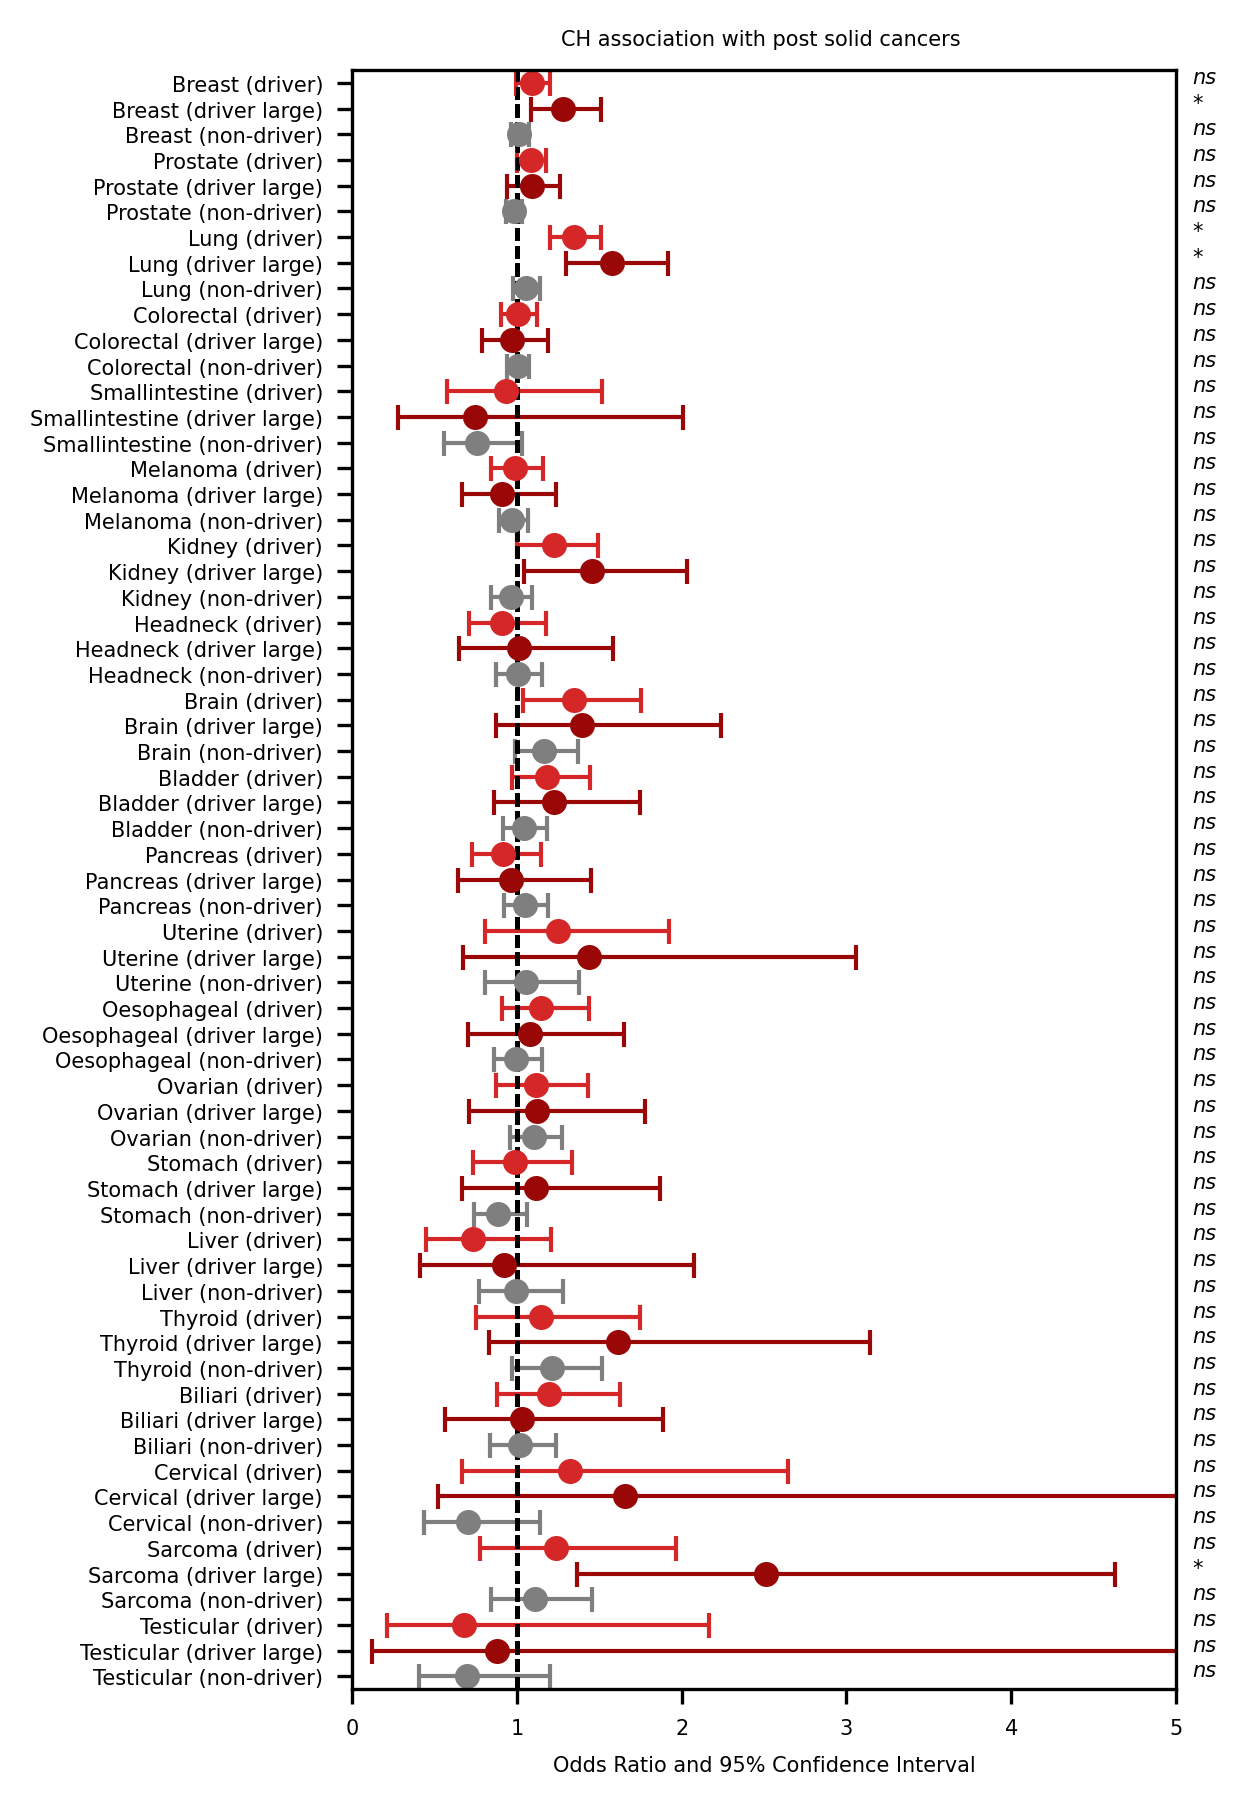

In [132]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4, 6))
xlimit = 5
ylimit = len(output)-1


output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
    if row['significant?'] == 'significant':
        if row['gene'].endswith('driver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '')], xerr=ci,
                     ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.1, ylimit-idx, '*', style='italic', size=5)
        elif row['gene'].endswith('nonDriver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_nonDriver', 'non-driver')], xerr=ci,
                     ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:grey", mec="tab:grey")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.1, ylimit-idx, '*', style='italic', size=5)
        elif row['gene'].endswith('big'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '').replace('_big', ' large')], xerr=ci,
                     ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#990707", mec="#990707")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.1, ylimit-idx, '*', style='italic', size=5)
    else:
        if row['gene'].endswith('driver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '')], xerr=ci,
                     ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.1, ylimit-idx, 'ns', style='italic', size=5)
        elif row['gene'].endswith('nonDriver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_nonDriver', 'non-driver')], xerr=ci,
                     ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:grey", mec="tab:grey")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.1, ylimit-idx, 'ns', style='italic', size=5)
        elif row['gene'].endswith('big'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '').replace('_big', ' large')], xerr=ci,
                     ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#990707", mec="#990707")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.1, ylimit-idx, 'ns', style='italic', size=5)


        plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('CH association with post solid cancers ', fontdict={'size':5})
plt.tight_layout()
plt.xlim([0, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.savefig('postcancer_v2.png', dpi=400,  bbox_inches='tight')
plt.show()

# 3- Death association

In [161]:
import math

variables = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
variables = variables.reset_index(drop=True)
variables

,patient,age_recruitment_x,age_group_x,CH_driver,CH_driver_big,CH_driver_small,CH_potential,CH_nonDriver,num_CH_drivers,CH_driver_multiple,num_CH_potential,ASXL1_driver,ASXL1_passenger,ASXL1_potential,CHEK2_driver,CHEK2_passenger,CHEK2_potential,DNMT3A_driver,DNMT3A_passenger,DNMT3A_potential,GNAS_driver,GNAS_passenger,GNAS_potential,IDH2_driver,IDH2_passenger,IDH2_potential,MDM4_driver,MDM4_passenger,MDM4_potential,PPM1D_driver,PPM1D_passenger,PPM1D_potential,SF3B1_driver,SF3B1_passenger,SF3B1_potential,SRSF2_driver,SRSF2_passenger,SRSF2_potential,TET2_driver,TET2_passenger,TET2_potential,TP53_driver,TP53_passenger,TP53_potential,U2AF1_driver,U2AF1_passenger,U2AF1_potential,chromatin_gene_driver,DDR_gene_driver,splicing_gene_driver,chromatin_gene_passenger,DDR_gene_passenger,splicing_gene_passenger,chromatin_gene_potential,DDR_gene_potential,splicing_gene_potential,age_recruitment_y,age_group_y,eid,cancer,cancer2+,age_1cancer,years_tocancer1,cancer1_pre,type_1cancer,hemato_cancer,hematocancer_icd10_type,hematocancer_icd10_age,hematocancer_icd9_type,hematocancer_icd9_age,hematocancer_type,hematocancer_age,hematocancer_icd10_date,hematocancer_icd9_date,hematocancer_date,...,var_Myeloma_years,var_Myeloma_var,var_Myeloma_post,var_Myeloma_pre,var_Kidney_years,var_Kidney_var,var_Kidney_post,var_Kidney_pre,var_Head-neck_years,var_Head-neck_var,var_Head-neck_post,var_Head-neck_pre,var_Brain_years,var_Brain_var,var_Brain_post,var_Brain_pre,var_Bladder_years,var_Bladder_var,var_Bladder_post,var_Bladder_pre,var_Pancreas_years,var_Pancreas_var,var_Pancreas_post,var_Pancreas_pre,var_Uterine_years,var_Uterine_var,var_Uterine_post,var_Uterine_pre,var_Oesophageal_years,var_Oesophageal_var,var_Oesophageal_post,var_Oesophageal_pre,var_Ovarian_years,var_Ovarian_var,var_Ovarian_post,var_Ovarian_pre,var_Stomach_years,var_Stomach_var,var_Stomach_post,var_Stomach_pre,var_Liver_years,var_Liver_var,var_Liver_post,var_Liver_pre,var_Thyroid_years,var_Thyroid_var,var_Thyroid_post,var_Thyroid_pre,var_Biliari_years,var_Biliari_var,var_Biliari_post,var_Biliari_pre,var_Cervical_years,var_Cervical_var,var_Cervical_post,var_Cervical_pre,var_Sarcoma_years,var_Sarcoma_var,var_Sarcoma_post,var_Sarcoma_pre,var_Testicular_years,var_Testicular_var,var_Testicular_post,var_Testicular_pre,var_HNALL_years,var_HNALL_var,var_HNALL_post,var_HNALL_pre,40007-0.0,Death_status,Smoking,Packages_cigarettes,Smoking_1,Smoking_2,cancer1_post
0,1000019,54,51-55,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,54,51-55,1000019,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,1.0,75.0,NaN,1.0,0
1,1000022,53,51-55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,51-55,1000022,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,0.0,0.0,0
2,1000035,59,56-60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,56-60,1000035,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,1.0,11.5,NaN,1.0,0
3,1000046,45,38-45,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,45,38-45,1000046,1,0,53.3,8.3,0,D051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0

In [162]:
#perform logistic regression separetly
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf

def log_regression(target, lista):
    
    #we have exclude pre hematological cases
    CH_driver_multiple_matrix = variables[((variables['CH_nonDriver']==0) & (variables['CH_driver_multiple']==1)) | (variables['CH_potential'] == 0)]
    CH_driver_matrix = variables[variables['CH_nonDriver']==0]
    CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = variables[variables['CH_driver']==0]
    
    name = []
    OR = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith(('multiple')):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_multiple_matrix).fit()
        if gene.endswith(('_driver')):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        elif gene.endswith('big'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_big_matrix).fit()
        elif gene.endswith('small'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_small_matrix).fit() 
        elif gene.endswith('nonDriver'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
        else:
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=variables).fit()
        name.append(gene)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        pval.append(model_hematopost.pvalues[1])
    varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval'])
    return(varlist)

In [163]:
varlist = log_regression('Death_status',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.239770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.234728
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236867
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.235177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241298
         Iterations 8


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,1.261179,1.208355,1.316313,2.174253e-26,6.522760e-26,sig
1,CH_driver_multiple,1.650631,1.483627,1.836432,3.306112e-20,6.612224e-20,sig
2,CH_driver_big,1.565473,1.456251,1.682887,6.020136e-34,3.612081e-33,sig
3,CH_driver_small,1.120045,1.062723,1.180459,2.341077e-05,2.809292e-05,sig
4,CH_nonDriver,1.026849,0.999276,1.055182,5.641271e-02,5.641271e-02,ns
5,CH_potential,1.091432,1.065852,1.117626,4.812959e-13,7.219439e-13,sig


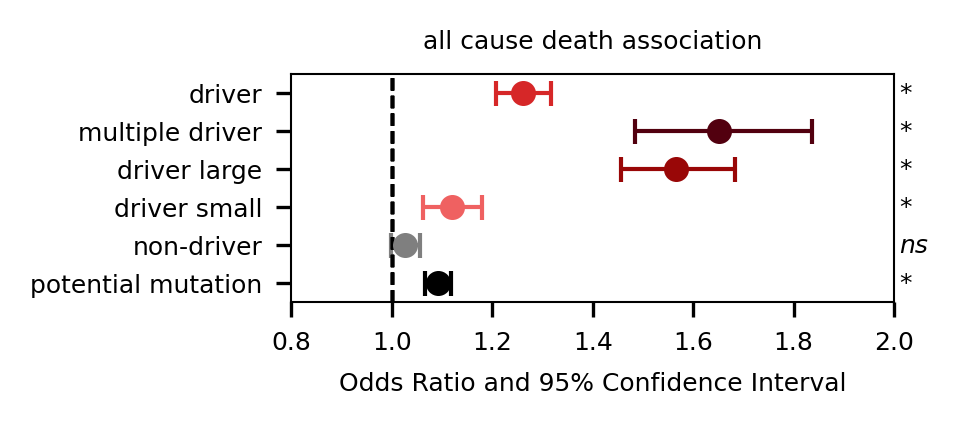

In [164]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.55, 1.4), dpi=300)
xlimit = 2
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, '*', style='italic', size =6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, 'ns', style='italic', size = 6)

        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('all cause death association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.8, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
#plt.savefig('death.png', dpi=400)
plt.show()

# 4- Smoking

In [165]:
import math

variables = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
variables = variables.reset_index(drop=True)
variables

,patient,age_recruitment_x,age_group_x,CH_driver,CH_driver_big,CH_driver_small,CH_potential,CH_nonDriver,num_CH_drivers,CH_driver_multiple,num_CH_potential,ASXL1_driver,ASXL1_passenger,ASXL1_potential,CHEK2_driver,CHEK2_passenger,CHEK2_potential,DNMT3A_driver,DNMT3A_passenger,DNMT3A_potential,GNAS_driver,GNAS_passenger,GNAS_potential,IDH2_driver,IDH2_passenger,IDH2_potential,MDM4_driver,MDM4_passenger,MDM4_potential,PPM1D_driver,PPM1D_passenger,PPM1D_potential,SF3B1_driver,SF3B1_passenger,SF3B1_potential,SRSF2_driver,SRSF2_passenger,SRSF2_potential,TET2_driver,TET2_passenger,TET2_potential,TP53_driver,TP53_passenger,TP53_potential,U2AF1_driver,U2AF1_passenger,U2AF1_potential,chromatin_gene_driver,DDR_gene_driver,splicing_gene_driver,chromatin_gene_passenger,DDR_gene_passenger,splicing_gene_passenger,chromatin_gene_potential,DDR_gene_potential,splicing_gene_potential,age_recruitment_y,age_group_y,eid,cancer,cancer2+,age_1cancer,years_tocancer1,cancer1_pre,type_1cancer,hemato_cancer,hematocancer_icd10_type,hematocancer_icd10_age,hematocancer_icd9_type,hematocancer_icd9_age,hematocancer_type,hematocancer_age,hematocancer_icd10_date,hematocancer_icd9_date,hematocancer_date,...,var_Myeloma_years,var_Myeloma_var,var_Myeloma_post,var_Myeloma_pre,var_Kidney_years,var_Kidney_var,var_Kidney_post,var_Kidney_pre,var_Head-neck_years,var_Head-neck_var,var_Head-neck_post,var_Head-neck_pre,var_Brain_years,var_Brain_var,var_Brain_post,var_Brain_pre,var_Bladder_years,var_Bladder_var,var_Bladder_post,var_Bladder_pre,var_Pancreas_years,var_Pancreas_var,var_Pancreas_post,var_Pancreas_pre,var_Uterine_years,var_Uterine_var,var_Uterine_post,var_Uterine_pre,var_Oesophageal_years,var_Oesophageal_var,var_Oesophageal_post,var_Oesophageal_pre,var_Ovarian_years,var_Ovarian_var,var_Ovarian_post,var_Ovarian_pre,var_Stomach_years,var_Stomach_var,var_Stomach_post,var_Stomach_pre,var_Liver_years,var_Liver_var,var_Liver_post,var_Liver_pre,var_Thyroid_years,var_Thyroid_var,var_Thyroid_post,var_Thyroid_pre,var_Biliari_years,var_Biliari_var,var_Biliari_post,var_Biliari_pre,var_Cervical_years,var_Cervical_var,var_Cervical_post,var_Cervical_pre,var_Sarcoma_years,var_Sarcoma_var,var_Sarcoma_post,var_Sarcoma_pre,var_Testicular_years,var_Testicular_var,var_Testicular_post,var_Testicular_pre,var_HNALL_years,var_HNALL_var,var_HNALL_post,var_HNALL_pre,40007-0.0,Death_status,Smoking,Packages_cigarettes,Smoking_1,Smoking_2,cancer1_post
0,1000019,54,51-55,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,54,51-55,1000019,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,1.0,75.0,NaN,1.0,0
1,1000022,53,51-55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,51-55,1000022,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,0.0,0.0,0
2,1000035,59,56-60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,56-60,1000035,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,1.0,11.5,NaN,1.0,0
3,1000046,45,38-45,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,45,38-45,1000046,1,0,53.3,8.3,0,D051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0

In [166]:
#perform logistic regression separetly
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf

def log_regression_pre(target, lista):
    
    #we have exclude pre hematological cases
    CH_driver_multiple_matrix = variables[((variables['CH_nonDriver']==0) & (variables['CH_driver_multiple']==1)) | (variables['CH_potential'] == 0)]
    CH_driver_matrix = variables[variables['CH_nonDriver']==0]
    CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = variables[variables['CH_driver']==0]
    
    name = []
    OR = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith(('multiple')):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_multiple_matrix).fit()
        if gene.endswith(('_driver')):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        elif gene.endswith('big'):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_big_matrix).fit()
        elif gene.endswith('small'):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_small_matrix).fit() 
        elif gene.endswith('nonDriver'):
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
        else:
            model_hematopost = smf.logit(formula= gene+' ~ 1 + '+target+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=variables).fit()
        name.append(gene)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        pval.append(model_hematopost.pvalues[1])
#         sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval'])
    return(varlist)

In [167]:
varlist = log_regression_pre('Smoking_2',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.264081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031907
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.036424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.210053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.567681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622580
         Iterations 5


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,1.118775,1.090317,1.147975,1.370497e-17,8.222983e-17,sig
1,CH_driver_multiple,1.215228,1.127258,1.310064,3.688682e-07,5.533022e-07,sig
2,CH_driver_big,1.130506,1.077290,1.186350,6.155856e-07,7.387027e-07,sig
3,CH_driver_small,1.109570,1.076552,1.143602,1.524252e-11,4.572755e-11,sig
4,CH_nonDriver,1.009172,0.995111,1.023431,2.021772e-01,2.021772e-01,ns
5,CH_potential,1.035409,1.022434,1.048548,6.359644e-08,1.271929e-07,sig


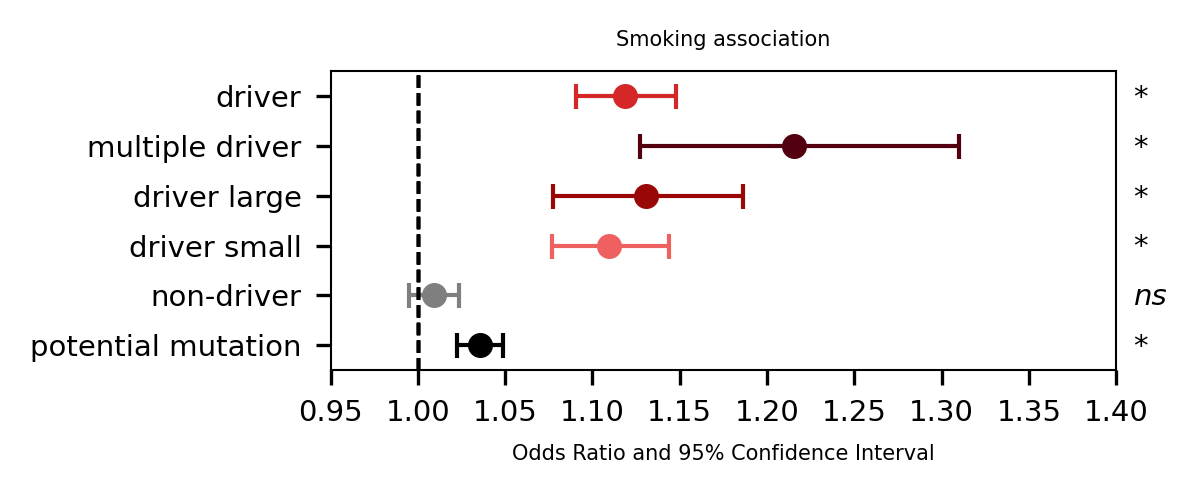

In [168]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.5, 1.6), dpi=300)
xlimit = 1.4
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, '*', style='italic', size =7)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, 'ns', style='italic', size = 7)

        plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('Smoking association', fontdict={'size':5})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
#plt.savefig('smoking.png', dpi=400)
plt.show()

In [144]:
variables_genes = [
    'DNMT3A_driver','DNMT3A_driver_big', 'DNMT3A_passenger',
    'TET2_driver','TET2_driver_big', 'TET2_passenger',
    'ASXL1_driver', 'ASXL1_driver_big', 'ASXL1_passenger',
    'CHEK2_driver', 'CHEK2_driver_big', 'CHEK2_passenger',
    'TP53_driver','TP53_driver_big', 'TP53_passenger',
    'PPM1D_driver','PPM1D_driver_big', 'PPM1D_passenger',
    'SF3B1_driver','SF3B1_driver_big', 'SF3B1_passenger',
    'SRSF2_driver','SRSF2_driver_big', 'SRSF2_passenger',
    'U2AF1_driver','U2AF1_driver_big', 'U2AF1_passenger',
    'GNAS_driver','GNAS_driver_big', 'GNAS_passenger',
    'IDH2_driver','IDH2_driver_big', 'IDH2_passenger',
    'MDM4_driver','MDM4_driver_big', 'MDM4_passenger',
    'chromatin_gene_driver', 'chromatin_gene_driver_big', 'chromatin_gene_passenger',
    'DDR_gene_driver', 'DDR_gene_driver_big', 'DDR_gene_passenger',
    'splicing_gene_driver', 'splicing_gene_driver_big', 'splicing_gene_passenger']

def log_reg_multi_pre(target):
    
    ## Ignore warning
    from tqdm import tqdm
    import warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    warnings.simplefilter('ignore', ConvergenceWarning)
    warnings.simplefilter('ignore', RuntimeWarning)

    ## Loop of logistic regressions
    gene_results = []
    
    
    for gene in tqdm(variables_genes):
        gen = gene.split('_')[0]
        mat_genes = gene_matrix(variables, gen)
        
        #set matrixes
        if gene.endswith(('multiple')):
            mat_gene = mat_genes[((mat_genes['CH_nonDriver']==0) & (mat_genes['CH_driver_multiple']==1)) | (mat_genes['CH_potential'] == 0)]
        elif gene.endswith(('_driver')):
            mat_gene = mat_genes[mat_genes['CH_nonDriver'] == 0]
        elif gene.endswith(('big')):
            mat_gene = mat_genes[(mat_genes['CH_nonDriver'] == 0) & (mat_genes['CH_driver_small'] == 0)]
        elif gene.endswith(('small')):
            mat_gene = mat_genes[(mat_genes['CH_nonDriver'] == 0) & (mat_genes['CH_driver_big'] == 0)]
        elif gene.endswith(('nonDriver', 'passenger')):
            mat_gene = mat_genes[mat_genes['CH_driver'] == 0]
        elif gene.endswith(('potential')):
            mat_gene = mat_genes
        else:
            print('no matrix assaigned')
        
    
        ## Get number of mutated samples and percentage
        num_mut = len(mat_gene[(mat_gene[target] == 1)])
        num_mut_can = len(mat_gene[(mat_gene[target] == 1) & (mat_gene[gene.replace('_big', '')] == 1)])
        if num_mut > 0:
            per_mut = round(num_mut_can / num_mut * 100, 2)
        else:
            per_mut = 0
    
        ## Logistic regression
        formula= gene.replace('_big', '')+' ~ 1 + age_recruitment_x + '+target+' + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10'

        ## Exception to avoid LinAlgError
        try:
            
            # Logistic regression
            model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
            # Get parameters from the logistic regression
            p = model.pvalues[2]
    
            odds = np.exp(model.params[2])
            conint1 = np.exp(model.conf_int().iloc[2,0])
            conint2 = np.exp(model.conf_int().iloc[2,1])
            prsquared = model.prsquared
            
            results = [gene.replace('passenger','nondriver'), num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
        except np.linalg.LinAlgError as err:
            print("LinAlgError:")
            print(gene, num_mut, num_mut_can, per_mut)
            results = [gene.replace('passenger','nondriver'), num_mut, num_mut_can, per_mut, 1, np.nan, np.nan, np.nan, np.nan]
            
    
        ## Append results    
        gene_results.append(results)
    
    # Get dataframe
    output = pd.DataFrame(gene_results, columns=["gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
    output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
    output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
    output = output[["gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]
    return(output)

In [147]:
### 4. Myeloid cancer POST
output = log_reg_multi_pre('Smoking_2')
output

100%|██████████| 45/45 [01:36<00:00,  2.14s/it]


,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,DNMT3A_driver,149509,6865,4.59,4.480746e-15,2.016336e-13,significant,1.148293,1.109280,1.188678,0.018149
1,DNMT3A_driver_big,144157,1513,1.05,1.170701e-04,6.585195e-04,significant,1.153172,1.072513,1.239896,0.021439
2,DNMT3A_nondriver,146655,4011,2.73,4.849387e-04,2.424693e-03,significant,1.081001,1.034722,1.129350,0.001475
3,TET2_driver,145134,2490,1.72,5.913404e-02,2.217527e-01,not significant,0.949076,0.898932,1.002017,0.008752
4,TET2_driver_big,143425,781,0.54,5.259049e-01,6.068133e-01,not significant,0.969189,0.879851,1.067598,0.014567
...,...,...,...,...,...,...,...,...,...,...,...
40,DDR_gene_driver_big,143263,619,0.43,2.319348e-02,9.488243e-02,not significant,1.137906,1.017813,1.272168,0.005268
41,DDR_gene_nondriver,151717,9073,5.98,4.123813e-01,5.154767e-01,not significant,0.987980,0.959823,1.016964,0.002501
42,splicing_gene_driver,143177,533,0.37,1.450157e-05,1.087618e-04,significant,1.334597,1.171361,1.520580,0.027611
43,splicing_gene_driver_big,142833,189,0.13,7.146344e-03,3.215855e-02,significant,1.360234,1.087075,1.702033,0.045750


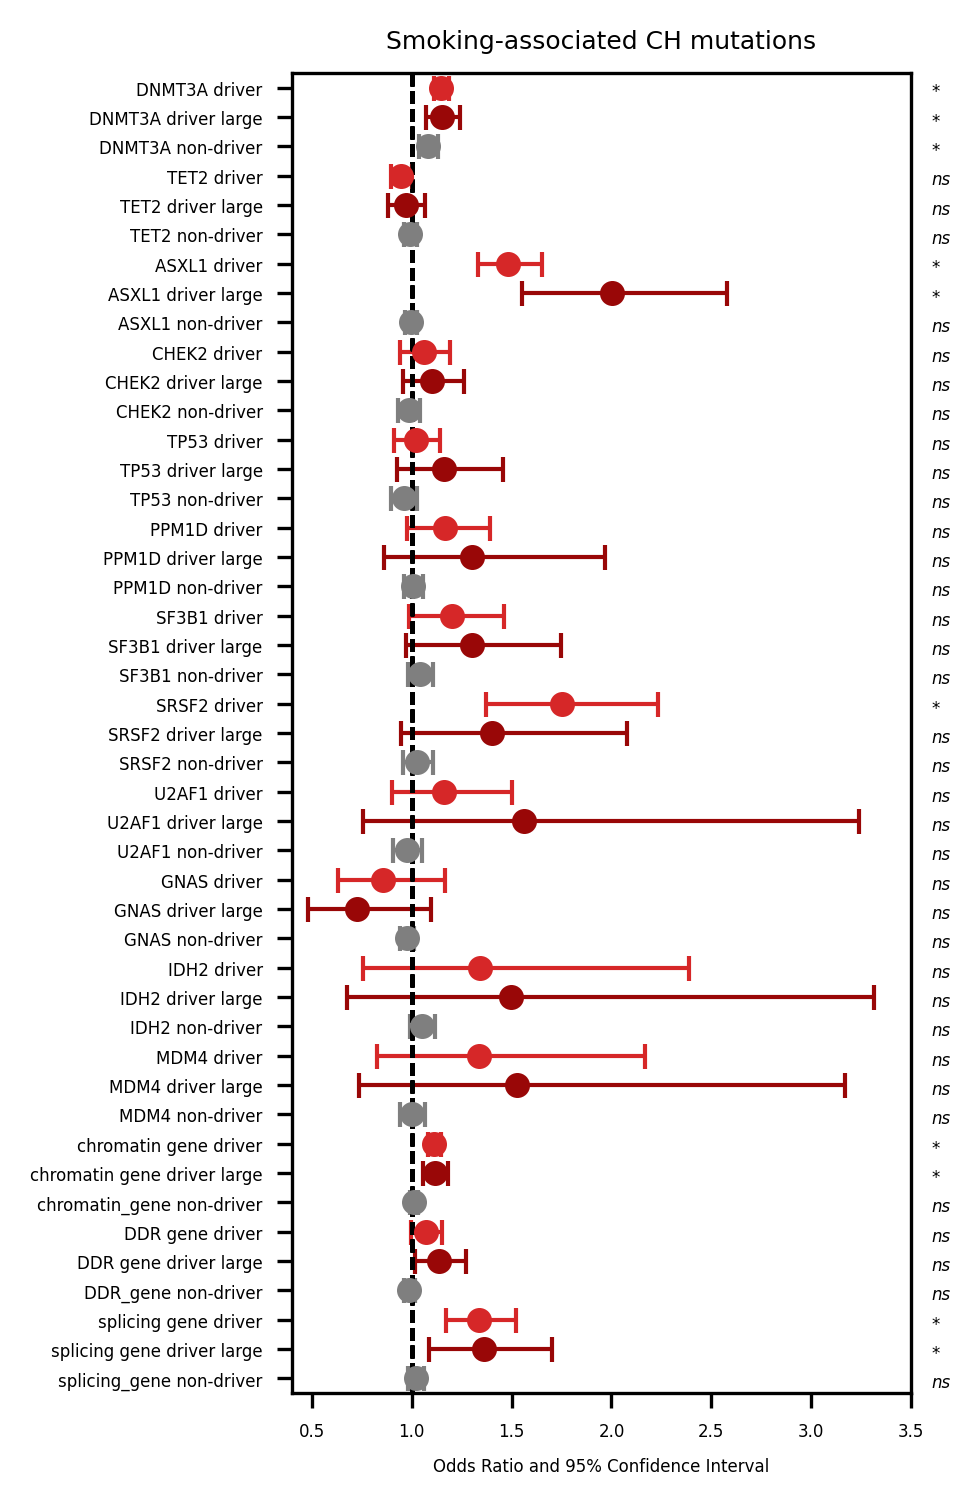

In [148]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.3, 5))
xlimit = 3.5
ylimit = len(output)-1

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
   
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('_', ' ')], xerr=ci,
                 ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:red", mec="tab:red")

    elif 'non' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('_nondriver', ' non-driver')], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")

    elif 'big' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=[row.gene.replace('_', ' ').replace('big', 'large')], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
          
    if row['significant?'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.1, ylimit-idx-0.3, '*', style='italic', size=4)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.1, ylimit-idx-0.3, 'ns', style='italic', size=4)
        

        plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=4)
ax.set_title('Smoking-associated CH mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.4, xlimit])
ax.set_ylim(-.5, ylimit+.5)
#plt.savefig('smoking_2_gene.png', dpi=400)
plt.show()

# 5- CVD

In [12]:
### Read cardio vascular diseases features per patient (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_siddharta = pd.read_csv('../../../Paper_data/UKB_clinic_info/cvd_ukb450k_Siddharta_670124_je.txt.gz', sep="\t")
patient_siddharta = patient_siddharta.rename({'eid': 'patient'}, axis=1)
patient_siddharta.columns

Index(['patient', 'var_MI_years', 'var_MI_var', 'var_MI_post', 'var_MI_pre',
       'var_STR_years', 'var_STR_var', 'var_STR_post', 'var_STR_pre',
       'var_ISTR_years', 'var_ISTR_var', 'var_ISTR_post', 'var_ISTR_pre',
       'var_CAD_years', 'var_CAD_var', 'var_CAD_post', 'var_CAD_pre',
       'var_HF_years', 'var_HF_var', 'var_HF_post', 'var_HF_pre',
       'var_AF_years', 'var_AF_var', 'var_AF_post', 'var_AF_pre'],
      dtype='object')

In [13]:
### Merge
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_siddharta,  how='inner',
                              on='patient')

In [191]:
# Include atherosclerosis
ukb200K_ch_cancer['var_ATH_var'] = ukb200K_ch_covariables['I70_var']
ukb200K_ch_cancer['var_ATH_years'] = ukb200K_ch_covariables['I70_years']
ukb200K_ch_cancer['var_ATH_post'] = ukb200K_ch_covariables['I70_post']
ukb200K_ch_cancer['var_ATH_pre'] = ukb200K_ch_covariables['I70_pre']

In [192]:
#Include the new variables
ukb200K_ch_cancer['DYSL_cov'] = ukb200K_ch_covariables['DYSL_cov']
ukb200K_ch_cancer['HYP_cov'] = ukb200K_ch_covariables['HYP_cov']
ukb200K_ch_cancer['DMT2_cov'] = ukb200K_ch_covariables['DMT2_cov']
ukb200K_ch_cancer['BMI_cov'] = ukb200K_ch_covariables['BMI_cov']

In [14]:
# Composite CVD definition
yeears = ['var_MI_years', 'var_STR_years', 'var_ISTR_years', 'var_CAD_years', 'var_HF_years', 'var_AF_years', 'var_ATH_years']
ukb200K_ch_cancer['var_CVD_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_CVD_var'] = np.where(ukb200K_ch_cancer['var_CVD_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_CVD_post'] = np.where(ukb200K_ch_cancer['var_CVD_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_CVD_pre'] = np.where(ukb200K_ch_cancer['var_CVD_years'] < 0, 1, 0)

In [ ]:
ukb200K_ch_cvd_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cvd_logistic = ukb200K_ch_cvd_logistic.reset_index(drop=True)

In [176]:
Diction_CVD = {
 'MI':'Miocardial infraction',
 'STR':'Stroke',
 'ISTR':'Ischemic stroke',
 'CAD':'Coronary artery disease',
 'HF':'Heart failure',
 'AF':'Atrial Fibrillation',
 'ATH':'Atherosclerosis',
 'CVD':'Composite'
}

In [209]:
## Ignore warning
from tqdm import tqdm
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

gene_results = []

cdv_variables=['var_MI_var',
 'var_STR_var',
 'var_ISTR_var',
 'var_CAD_var',
 'var_HF_var',
 'var_AF_var',
 'var_ATH_var',
 'var_CVD_var']

for target in tqdm(cdv_variables):
    
    ## Loop of logistic regressions
    
    for gene in ['CH_driver', 'CH_driver_big', 'CH_nonDriver']:
                
        #set matrixes
        if gene.endswith(('driver')):
            mat_gene = ukb200K_ch_cvd_logistic[ukb200K_ch_cvd_logistic['CH_nonDriver'] == 0]
        elif gene.endswith(('big')):
            mat_gene = ukb200K_ch_cvd_logistic[(ukb200K_ch_cvd_logistic['CH_nonDriver'] == 0) & (ukb200K_ch_cvd_logistic['CH_driver_small'] == 0)]
        elif gene.endswith(('small')):
            mat_gene = ukb200K_ch_cvd_logistic[(ukb200K_ch_cvd_logistic['CH_nonDriver'] == 0) & (ukb200K_ch_cvd_logistic['CH_driver_big'] == 0)]
        elif gene.endswith(('nonDriver')):
            mat_gene = ukb200K_ch_cvd_logistic[ukb200K_ch_cvd_logistic['CH_driver'] == 0]
        elif gene.endswith(('potential')):
            mat_gene = ukb200K_ch_cvd_logistic
        else:
            print('no matrix assaigned')
    
        ## Get number of mutated samples and percentage
        num_mut = len(mat_gene[(mat_gene[gene] == 1)])
        num_mut_can = len(mat_gene[(mat_gene[gene] == 1) & (mat_gene[target] == 1)])
        if num_mut > 0:
            per_mut = round(num_mut_can / num_mut * 100, 2)
        else:
            per_mut = 0
    
        ## Logistic regression
        formula = target+' ~ 1 + age_recruitment_x + '+gene+' + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + DYSL_cov+ HYP_cov + DMT2_cov + BMI_cov + Smoking_2'

        ## Exception to avoid LinAlgError
        try:
            
            # Logistic regression
            model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
            # Get parameters from the logistic regression
            p = model.pvalues[2]
            odds = np.exp(model.params[2])
            conint1 = np.exp(model.conf_int().iloc[2,0])
            conint2 = np.exp(model.conf_int().iloc[2,1])
            prsquared = model.prsquared
            
            results = [Diction_CVD[target.split('_')[1]]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
        except Exception as ex:
            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            message = template.format(type(ex).__name__, ex.args)
            print(target, gene, num_mut, num_mut_can, per_mut, message)
            continue
            
    
        ## Append results    
        gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
output = output[["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]
output

100%|██████████| 8/8 [01:00<00:00,  7.58s/it]


,variable,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,Miocardial infraction (CH_driver),CH_driver,26184,1813,6.92,0.606476,0.882272,not significant,1.014188,0.961254,1.070038,0.165682
1,Miocardial infraction (CH_driver_big),CH_driver_big,7050,517,7.33,0.817956,0.912167,not significant,1.011527,0.917471,1.115226,0.166508
2,Miocardial infraction (CH_nonDriver),CH_nonDriver,109937,6259,5.69,0.451483,0.722373,not significant,1.012225,0.980710,1.044752,0.168008
3,Stroke (CH_driver),CH_driver,26184,1191,4.55,0.020628,0.099015,not significant,1.077652,1.011528,1.148099,0.087430
4,Stroke (CH_driver_big),CH_driver_big,7050,357,5.06,0.016149,0.096896,not significant,1.147846,1.025869,1.284326,0.087133
5,Stroke (CH_nonDriver),CH_nonDriver,109937,3940,3.58,0.334743,0.669486,not significant,1.019023,0.980742,1.058799,0.086896
6,Ischemic stroke (CH_driver),CH_driver,26184,565,2.16,0.874160,0.912167,not significant,0.992766,0.907456,1.086095,0.091870
7,Ischemic stroke (CH_driver_big),CH_driver_big,7050,165,2.34,0.865514,0.912167,not significant,1.014055,0.862809,1.191813,0.091820
8,Ischemic stroke (CH_nonDriver),CH_nonDriver,109937,1944,1.77,0.944638,0.944638,not significant,1.001899,0.949658,1.057014,0.090806
9,Coronary artery disease (CH_driver),CH_driver,26184,3418,13.05,0.624943,0.882272,not significant,1.010463,0.969164,1.053521,0.189352


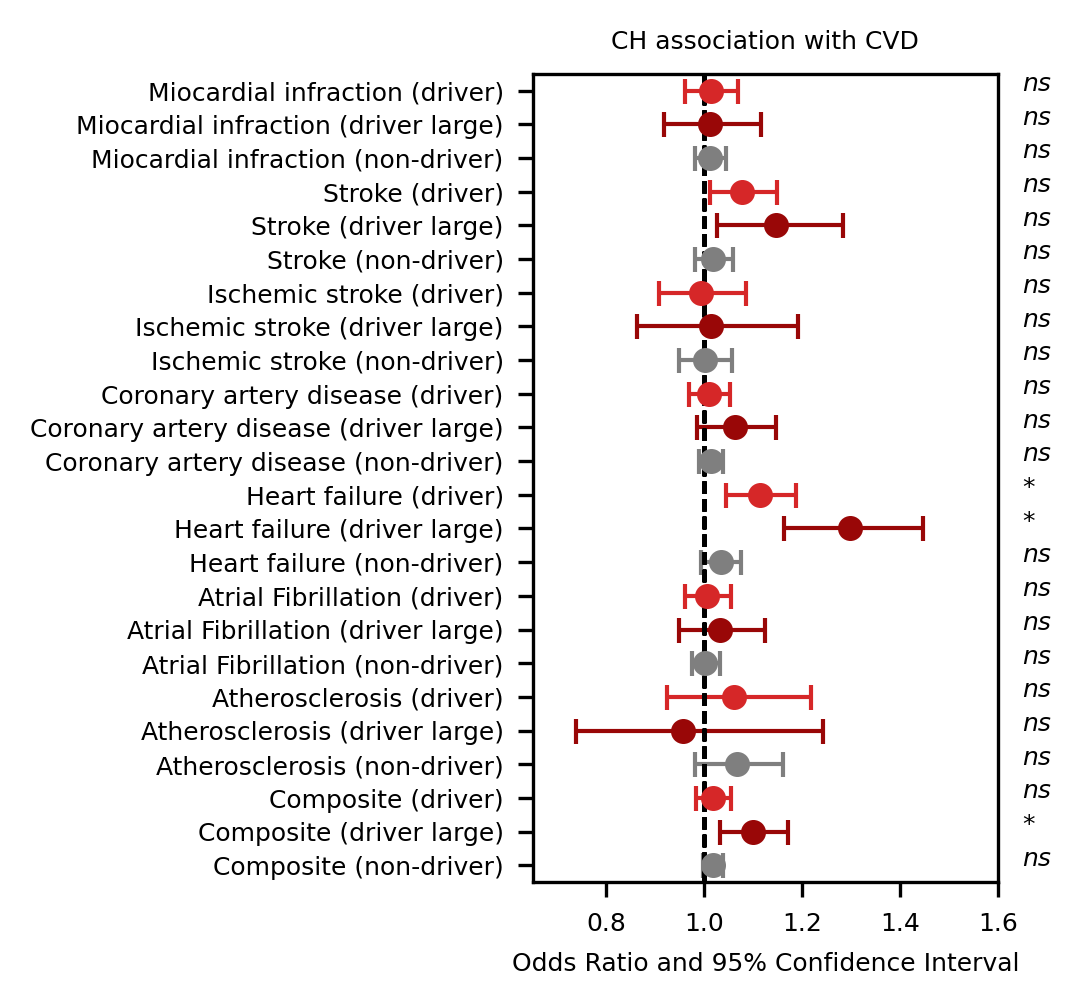

In [210]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2,3.5), dpi=300)
xlimit = 1.6
ylimit = len(output)-1

# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
# sns.set_style("default")
# sns.set()

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
    if row['significant?'] == 'significant':
        if row['gene'].endswith('driver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '')], xerr=ci,
                     ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.05, ylimit-idx, '*', style='italic', size=6)
        elif row['gene'].endswith('nonDriver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_nonDriver', 'non-driver')], xerr=ci,
                     ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:grey", mec="tab:grey")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.05, ylimit-idx, '*', style='italic', size=6)
        elif row['gene'].endswith('big'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '').replace('_big', ' large')], xerr=ci,
                     ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#990707", mec="#990707")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.05, ylimit-idx, '*', style='italic', size=6)
    else:
        if row['gene'].endswith('driver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '')], xerr=ci,
                     ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.05, ylimit-idx, 'ns', style='italic', size=6)
        elif row['gene'].endswith('nonDriver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_nonDriver', 'non-driver')], xerr=ci,
                     ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:grey", mec="tab:grey")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.05, ylimit-idx, 'ns', style='italic', size=6)
        elif row['gene'].endswith('big'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable.replace('CH_', '').replace('_big', ' large')], xerr=ci,
                     ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#990707", mec="#990707")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.05, ylimit-idx, 'ns', style='italic', size=6)            
            
        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('CH association with CVD', fontdict={'size':6})

plt.xlim([0.65, xlimit])
ax.set_ylim(-.5, ylimit+.5)

plt.savefig('CVD_var.png', dpi=400, bbox_inches='tight')
plt.show()

### Heart Failure

In [177]:
import math

variables = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
variables = variables.reset_index(drop=True)
variables

,patient,age_recruitment_x,age_group_x,CH_driver,CH_driver_big,CH_driver_small,CH_potential,CH_nonDriver,num_CH_drivers,CH_driver_multiple,num_CH_potential,ASXL1_driver,ASXL1_passenger,ASXL1_potential,CHEK2_driver,CHEK2_passenger,CHEK2_potential,DNMT3A_driver,DNMT3A_passenger,DNMT3A_potential,GNAS_driver,GNAS_passenger,GNAS_potential,IDH2_driver,IDH2_passenger,IDH2_potential,MDM4_driver,MDM4_passenger,MDM4_potential,PPM1D_driver,PPM1D_passenger,PPM1D_potential,SF3B1_driver,SF3B1_passenger,SF3B1_potential,SRSF2_driver,SRSF2_passenger,SRSF2_potential,TET2_driver,TET2_passenger,TET2_potential,TP53_driver,TP53_passenger,TP53_potential,U2AF1_driver,U2AF1_passenger,U2AF1_potential,chromatin_gene_driver,DDR_gene_driver,splicing_gene_driver,chromatin_gene_passenger,DDR_gene_passenger,splicing_gene_passenger,chromatin_gene_potential,DDR_gene_potential,splicing_gene_potential,age_recruitment_y,age_group_y,eid,cancer,cancer2+,age_1cancer,years_tocancer1,cancer1_pre,type_1cancer,hemato_cancer,hematocancer_icd10_type,hematocancer_icd10_age,hematocancer_icd9_type,hematocancer_icd9_age,hematocancer_type,hematocancer_age,hematocancer_icd10_date,hematocancer_icd9_date,hematocancer_date,...,var_Stomach_years,var_Stomach_var,var_Stomach_post,var_Stomach_pre,var_Liver_years,var_Liver_var,var_Liver_post,var_Liver_pre,var_Thyroid_years,var_Thyroid_var,var_Thyroid_post,var_Thyroid_pre,var_Biliari_years,var_Biliari_var,var_Biliari_post,var_Biliari_pre,var_Cervical_years,var_Cervical_var,var_Cervical_post,var_Cervical_pre,var_Sarcoma_years,var_Sarcoma_var,var_Sarcoma_post,var_Sarcoma_pre,var_Testicular_years,var_Testicular_var,var_Testicular_post,var_Testicular_pre,var_HNALL_years,var_HNALL_var,var_HNALL_post,var_HNALL_pre,40007-0.0,Death_status,Smoking,Packages_cigarettes,Smoking_1,Smoking_2,cancer1_post,var_MI_years,var_MI_var,var_MI_post,var_MI_pre,var_STR_years,var_STR_var,var_STR_post,var_STR_pre,var_ISTR_years,var_ISTR_var,var_ISTR_post,var_ISTR_pre,var_CAD_years,var_CAD_var,var_CAD_post,var_CAD_pre,var_HF_years,var_HF_var,var_HF_post,var_HF_pre,var_AF_years,var_AF_var,var_AF_post,var_AF_pre,var_ATH_var,var_ATH_years,var_ATH_post,var_ATH_pre,DYSL_cov,HYP_cov,DMT2_cov,BMI_cov,var_CVD_years,var_CVD_var,var_CVD_post,var_CVD_pre
0,1000019,54,51-55,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,54,51-55,1000019,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,1.0,75.0,NaN,1.0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,-4.443623,1,0,1,NaN,0,0,0,NaN,0,0,0,0,NaN,0,0,1.0,1,0,1.0,-4.443623,1,0,1
1,1000022,53,51-55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,51-55,1000022,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,0.0,0.0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,NaN,0,0,0.0,1,0,0.0,NaN,0,0,0
2,1000035,59,56-60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,56-60,1000035,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,1.0,11.5,NaN,1.0,0,NaN,0,0,0,8.153487,1,1,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,NaN,0,0,0.0,1,0,0.0,8.153487,1,1,0
3,1000046,45,38-45,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,45,38-45,1000046,1,0,53.3,8.3,0,D051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,0.0,0.0,1,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,NaN,0,0,1.0,1,0,0.0,NaN,0,0,0
4,1000054,65,61-65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,61-65,10

In [178]:
## Loop of logistic regressions
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf

gene_results = []
for gene in ['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential']:
        
    #set matrixes
    if gene.endswith('multiple'):
        mat_gene = variables[((variables['CH_nonDriver']==0) & (variables['CH_driver_multiple']==1)) | (variables['CH_potential'] == 0)]
    elif gene.endswith(('_driver')):
        mat_gene = variables[variables['CH_nonDriver']==0]
    elif gene.endswith(('big')):
        mat_gene = variables[(variables['CH_nonDriver']==0) & (variables['CH_driver_small']==0)]
    elif gene.endswith(('small')):
        mat_gene = variables[(variables['CH_nonDriver']==0) & (variables['CH_driver_big']==0)]
    elif gene.endswith(('nonDriver')):
        mat_gene = variables[variables['CH_driver']==0]
    elif gene.endswith(('potential')):
        mat_gene = variables
    else:
        print('no matrix assaigned')
                
    
    ## Get number of mutated samples and percentage
    num_mut = len(mat_gene[(mat_gene[gene] == 1)])
    num_mut_can = len(mat_gene[(mat_gene[gene] == 1) & (mat_gene['var_HF_post'] == 1)])
    if num_mut > 0:
        per_mut = round(num_mut_can / num_mut * 100, 2)
    else:
        per_mut = 0
    
    ## Logistic regression
    formula= 'var_HF_post ~ 1 + age_recruitment_x +'+gene+' + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + DYSL_cov+ HYP_cov + DMT2_cov + BMI_cov + Smoking_2'

    ## Exception
    try:
            
        # Logistic regression
        model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
        # Get parameters from the logistic regression
        p = model.pvalues[2]
        odds = np.exp(model.params[2])
        conint1 = np.exp(model.conf_int().iloc[2,0])
        conint2 = np.exp(model.conf_int().iloc[2,1])
        prsquared = model.prsquared
            
        results = [gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(gene, num_mut, num_mut_can, per_mut, message)
        results = [gene, num_mut, num_mut_can, per_mut, np.nan, np.nan, np.nan, np.nan, np.nan]
            
    
    ## Append results    
    gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
output = output[["gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]

output

,gene,num_mut,num_mut_can,per_mut,p_value,q_value,significant?,odds_ratio,confint_1st,confint_2nd,pseudoR2
0,CH_driver,26184,1078,4.12,0.000459,0.001377,significant,1.128870,1.054857,1.208076,0.148495
1,CH_driver_multiple,1691,89,5.26,0.126553,0.173648,not significant,1.192256,0.951481,1.493959,0.148504
2,CH_driver_big,7050,351,4.98,0.000008,0.000049,significant,1.300849,1.158869,1.460224,0.149185
3,CH_driver_small,18540,698,3.76,0.159147,0.173648,not significant,1.060908,0.977085,1.151922,0.148350
4,CH_nonDriver,109937,3255,2.96,0.173648,0.173648,not significant,1.029917,0.987098,1.074594,0.148390
5,CH_potential,148061,4835,3.27,0.000973,0.001947,significant,1.064417,1.025652,1.104648,0.147879


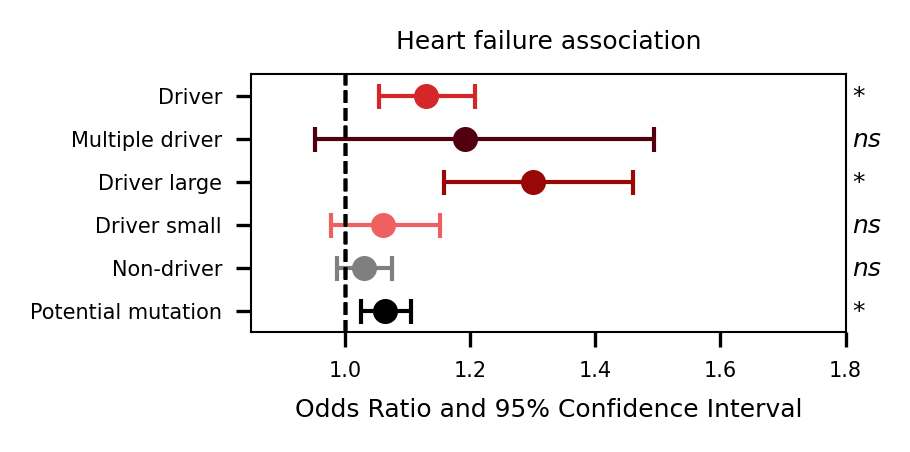

In [179]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(5, 1.5), dpi=300)
xlimit = 1.8
ylimit = len(output)-1

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['odds_ratio']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['odds_ratio']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['odds_ratio']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['significant?'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, '*', style='italic', size =6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.2, 'ns', style='italic', size = 6)

        plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('Heart failure association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.85, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

# 6. Infectious disease

In [17]:
### Read Infectious disease features per patient (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_infection = pd.read_csv('../../../Paper_data/UKB_clinic_info/Infection_ukb450k_670124_bacterial_infection.txt.gz',sep="\t")
patient_infection = patient_infection.rename({'eid': 'patient'}, axis=1)
patient_infection = patient_infection[patient_infection['patient'].isin(ukb200K_ch_cancer['patient'].tolist())]
patient_infection = patient_infection.reset_index(drop=True)
patient_infection.columns

Index(['patient', 'var_Sepsis_years', 'var_Sepsis_var', 'var_Sepsis_post',
       'var_Sepsis_pre', 'var_Pneumonia_years', 'var_Pneumonia_var',
       'var_Pneumonia_post', 'var_Pneumonia_pre', 'var_Gastroenteritis_years',
       ...
       'var_B95_post', 'var_B95_pre', 'var_B96_years', 'var_B96_var',
       'var_B96_post', 'var_B96_pre', 'var_B98_years', 'var_B98_var',
       'var_B98_post', 'var_B98_pre'],
      dtype='object', length=121)

In [18]:
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_infection,  how='inner',
                              on='patient')

In [182]:
# Remove cases with previoius hematological cancer
ukb200K_ch_cvd_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
#perform logistic regression separetly
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf
ukb200K_ch_cvd_logistic.CH_driver.sum()

38124

In [183]:
#perform logistic regression separetly
import statsmodels.stats.multitest as mtc
import statsmodels.formula.api as smf

def log_regression(target, lista):
    
    #we have exclude pre bacterial infection cases
    ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logistic[ukb200K_ch_cvd_logistic[target.replace('_post', '_pre')]==0]

    CH_driver_multiple_matrix = ukb200K_ch_cvd_logi[((ukb200K_ch_cvd_logi['CH_nonDriver']==0) & (ukb200K_ch_cvd_logi['CH_driver_multiple']==1)) | (ukb200K_ch_cvd_logi['CH_potential'] == 0)]
    CH_driver_matrix = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['CH_nonDriver']==0]
    CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
    CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
    CH_passengers_matrix = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['CH_driver']==0]
    
    name = []
    OR = []
    cilow = []
    ciup = []
    pval = []
    sig = []
    
    #run model
    for gene in lista:
        if gene.endswith(('multiple')):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2 + var_HNALL_post', data=CH_driver_multiple_matrix).fit()
        if gene.endswith(('_driver')):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10+ Smoking_2 + var_HNALL_post', data=CH_driver_matrix).fit()
        elif gene.endswith('big'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10+ Smoking_2 + var_HNALL_post', data=CH_driver_big_matrix).fit()
        elif gene.endswith('small'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10+ Smoking_2 + var_HNALL_post', data=CH_driver_small_matrix).fit() 
        elif gene.endswith('nonDriver'):
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2 + var_HNALL_post', data=CH_passengers_matrix).fit()
        else:
            model_hematopost = smf.logit(formula= target+' ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10+ Smoking_2 + var_HNALL_post', data=ukb200K_ch_cvd_logi).fit()
        name.append(gene)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        pval.append(model_hematopost.pvalues[1])
#         sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval'])
    return(varlist)

varlist = log_regression('var_Composite_any_infection_post',['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.326788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325236
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328845
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,q_value,sig
0,CH_driver,1.074041,1.032345,1.117421,0.000407,0.000688,sig
1,CH_driver_multiple,1.207923,1.086790,1.342556,0.000459,0.000688,sig
2,CH_driver_big,1.172586,1.092821,1.258173,0.000009,0.000057,sig
3,CH_driver_small,1.029871,0.982217,1.079838,0.223348,0.223348,ns
4,CH_nonDriver,1.026261,1.002991,1.050072,0.026751,0.032101,sig
5,CH_potential,1.041370,1.020349,1.062823,0.000098,0.000293,sig


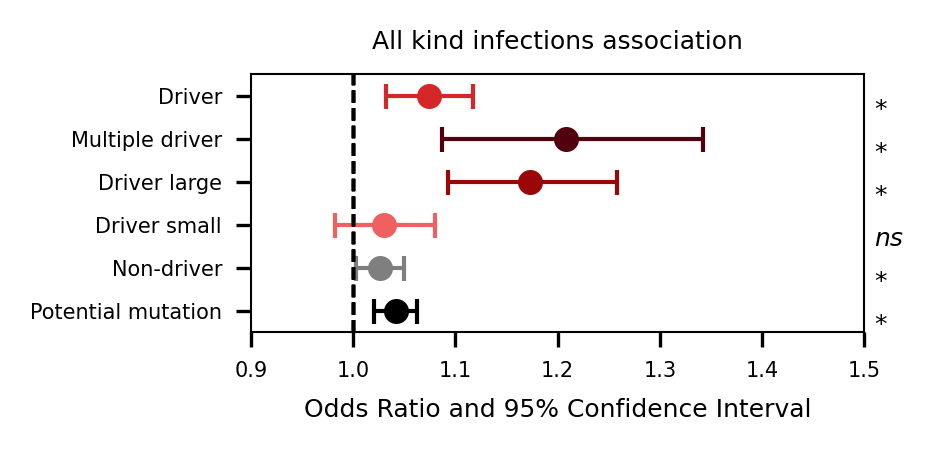

In [185]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.5, 1.5), dpi=300)
xlimit = 1.5
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'sig':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.5, '*', style='italic', size=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.01, ylimit-idx-0.5, 'ns', style='italic', size=6)

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('All kind infections association', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.9, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.show()

In [ ]:
## Ignore warning

variables = ['var_Composite_any_infection_post',
 'var_Bacterial_infections_post',
 'var_Viral_infections_post',
 'var_Fungal_Infections_post',
 'var_Sepsis_post',
 'var_Pneumonia_post',
 'var_Gastroenteritis_post',
 'var_Skin_infection_post',
 'var_Urinary_tract_infection_post']

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

gene_results = []

for target in variables:
    
    ukb200K_ch_cvd_logi = ukb200K_ch_cvd_logistic[ukb200K_ch_cvd_logistic[target.replace('_post', '_pre')]==0]
    
    ## Loop of logistic regressions
    for gene in ['CH_driver', 'CH_driver_big', 'CH_nonDriver']:
                
        #set matrixes
        if gene.endswith(('_driver')):
            mat_gene = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['CH_nonDriver'] == 0]
        elif gene.endswith(('big')):
            mat_gene = ukb200K_ch_cvd_logi[(ukb200K_ch_cvd_logi['CH_nonDriver'] == 0) & (ukb200K_ch_cvd_logi['CH_driver_small'] == 0)]
        elif gene.endswith(('small')):
            mat_gene = ukb200K_ch_cvd_logi[(ukb200K_ch_cvd_logi['CH_nonDriver'] == 0) & (ukb200K_ch_cvd_logi['CH_driver_big'] == 0)]
        elif gene.endswith(('nonDriver')):
            mat_gene = ukb200K_ch_cvd_logi[ukb200K_ch_cvd_logi['CH_driver'] == 0]
        elif gene.endswith(('potential')):
            mat_gene = ukb200K_ch_cvd_logi
        else:
            print('no matrix assaigned')
            
    ## Get number of mutated samples and percentage
        num_mut = len(mat_gene[(mat_gene[gene] == 1)])
        num_mut_can = len(mat_gene[(mat_gene[gene] == 1) & (mat_gene[target] == 1)])
        if num_mut > 0:
            per_mut = round(num_mut_can / num_mut * 100, 2)
        else:
            per_mut = 0
    
        ## Logistic regression
        formula = target+' ~ 1 + age_recruitment_x + '+gene+' + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2 + var_HNALL_post'

        ## Exception to avoid LinAlgError
        try:
            
            # Logistic regression
            model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
            # Get parameters from the logistic regression
            p = model.pvalues[2]
            odds = np.exp(model.params[2])
            conint1 = np.exp(model.conf_int().iloc[2,0])
            conint2 = np.exp(model.conf_int().iloc[2,1])
            prsquared = model.prsquared
            
            results = [target.split('_')[1]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, p, odds, conint1, conint2, prsquared]
        
        except Exception as ex:
            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            message = template.format(type(ex).__name__, ex.args)
            print(target, gene, num_mut, num_mut_can, per_mut, message)
            results = [target.split('_')[1]+' ('+gene+')', gene, num_mut, num_mut_can, per_mut, np.nan, np.nan, np.nan, np.nan, np.nan]
            
    
        ## Append results    
        gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value",
                                                 "odds_ratio","confint_1st", "confint_2nd", "pseudoR2"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in output.q_value]
output = output[["variable", "gene", "num_mut", "num_mut_can", "per_mut", "p_value", "q_value", "significant?",
                     "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2"]]
output

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4, 4))
xlimit = 1.6
ylimit = len(output)-1

for idx, row in output.iloc[::-1].iterrows():
    ci = [[row['odds_ratio'] - row['confint_1st']], [row['confint_2nd'] - row['odds_ratio']]]
    if row['significant?'] == 'significant':
        if row['gene'].endswith('driver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable], xerr=ci,
                     ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.01, ylimit-idx, '*', style='italic', size=5)
        elif row['gene'].endswith('nonDriver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable], xerr=ci,
                     ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:grey", mec="tab:grey")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.01, ylimit-idx, '*', style='italic', size=5)
        elif row['gene'].endswith('big'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable], xerr=ci,
                     ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#990707", mec="#990707")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.01, ylimit-idx, '*', style='italic', size=5)
    else:
        if row['gene'].endswith('driver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable], xerr=ci,
                     ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.01, ylimit-idx, 'ns', style='italic', size=5)
        elif row['gene'].endswith('nonDriver'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable], xerr=ci,
                     ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:grey", mec="tab:grey")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.01, ylimit-idx, 'ns', style='italic', size=5)
        elif row['gene'].endswith('big'):
            plt.errorbar(x=[row['odds_ratio']], y=[row.variable], xerr=ci,
                     ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#990707", mec="#990707")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            ax.text(xlimit+0.01, ylimit-idx, 'ns', style='italic', size=5)


        plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('CH association with Infectious diseases', fontdict={'size':5})
plt.tight_layout()
plt.xlim([.9, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.show()